# Análisis Exploratorio de Datos (**EDA**) Multimodal

Este *notebook* tiene como objetivo caracterizar y validar los datos previamente a la fase de entrenamiento. El análisis se estructura en tres etapas secuenciales:
1. **EDA Específico - MELD**: Análisis del dataset `MELD_clean.csv` preprocesado. 
2. **EDA Específico - IEMOCAP**: Análisis del dataset `IEMOCAP_clean.csv` preprocesado. 
3. **EDA Global y Comparativo**: Análisis del **Dataset Global** resultante de la integración de ambos. 

El propósito de esta estratificación es revelar patrones intrínsecos y posibles sesgos (como el desbalanceo de clases o la longitud de los textos) en cada fuente de datos por separado. Esto permite entender cómo contribuye cada dataset al **espacio latente global** que utilizarán los modelos multimodales y LLMs, asegurando una interpretación robusta de los resultados finales.

Inicialmente, se cargan las librerías y paquetes necesarios para la ejecución de este *notebook*.

In [4]:
!pip install wordcloud opencv-python tqdm

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
from PIL import Image

DATA_ROOT = "../data"  # Se indica la ruta donde se encuentran todos los datos para el proyecto
RAW_PATH = os.path.join(DATA_ROOT, "RAW")  # Ruta donde se encuentran los datos en crudo (RAW) para el proyecto
MELD_VIDEO_PATH = os.path.join(RAW_PATH, "MELD") # Ruta donde se encuentran los vídeos originales (raw) de MELD
PROCESSED_PATH = os.path.join(DATA_ROOT, "PROCESSED") # Ruta donde se encuentran los clips de vídeo procesados de IEMOCAP
FIGURAS_PATH = "../figuras"  # Ruta donde se guardarán las figuras generadas

MELD_CLEAN_CSV = os.path.join(PROCESSED_PATH, "MELD_clean.csv") #Ruta al archivo CSV preprocesado de MELD 
IEMOCAP_CLEAN_CSV = os.path.join(PROCESSED_PATH, "IEMOCAP_clean.csv") #Ruta al archivo CSV preprocesado de IEMOCAP

GLOBAL_CSV_PATH = os.path.join(PROCESSED_PATH, "Multimodal_Stress_Dataset.csv")

---

### **1. Análisis Dataset MELD (`MELD_clean`)**.

El dataset **MELD** es un corpus multimodal jerárquico. La unidad atómica de análisis es la 'Utterance' (Expresión), que consiste en un clip audiovisual breve conteniendo el turno de palabra de un único interlocutor. Estas expresiones se agrupan secuencialmente en 'Dialogues' (Diálogos), permitiendo preservar el contexto conversacional. Aunque los diálogos provienen de escenas multiparte, la mayoría de las interacciones modeladas son de naturaleza diádica (intercambio entre dos interlocutores principales).

In [47]:
# Carga de los datos ya preprocesados
file_path = MELD_CLEAN_CSV
if os.path.exists(file_path):
    df_meld = pd.read_csv(file_path)
    display(df_meld.head()) 
else:
    print(f"No se encuentra el archivo en {file_path}")


Dialogue_ID  Utterance_ID        Unique_ID  \
0            0             0  train_dia0_utt0   
1            0             1  train_dia0_utt1   
2            0             2  train_dia0_utt2   
3            0             3  train_dia0_utt3   
4            0             4  train_dia0_utt4   

                                           Utterance   Emotion  target_stress  \
0  also I was the point person on my company's tr...   neutral              0   
1                   You must've had your hands full.   neutral              0   
2                            That I did. That I did.   neutral              0   
3      So let's talk a little bit about your duties.   neutral              0   
4                              My duties? All right.  surprise              0   

                   video_path                      audio_path  duration  \
0  train_splits/dia0_utt0.mp4  MELD_Audio/train_dia0_utt0.wav  5.672333   
1  train_splits/dia0_utt1.mp4  MELD_Audio/train_dia0_utt1.wav  1.501500   
2  train_splits/dia0_utt2.mp4  MELD_Audio/train_dia0_utt2.wav  2.919583   
3  train_splits/dia0_utt3.mp4  MELD_Audio/train_dia0_utt3.wav  2.752750   
4  train_splits/dia0_utt4.mp4  MELD_Audio/train_dia0_utt4.wav  6.464792   

           Speaker  split  word_count  
0         Chandler  train          16  
1  The Interviewer  train           6  
2         Chandler  train           6  
3  The Interviewer  train           9  
4         Chandler  train           4

In [7]:
df_meld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13704 entries, 0 to 13703
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dialogue_ID    13704 non-null  int64  
 1   Utterance_ID   13704 non-null  int64  
 2   Unique_ID      13704 non-null  object 
 3   Utterance      13704 non-null  object 
 4   Emotion        13704 non-null  object 
 5   target_stress  13704 non-null  int64  
 6   video_path     13704 non-null  object 
 7   audio_path     13704 non-null  object 
 8   duration       13704 non-null  float64
 9   Speaker        13704 non-null  object 
 10  split          13704 non-null  object 
 11  word_count     13704 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 1.3+ MB


Se indica un total de **13704** registros en el *dataset* ya preprocesado, estructurados en 12 variables: 5 de ellas numéricas (cuatro `int64` y una `float64`), 7 de tipo categórico o textual (`object`), donde **6 variables** mostradas (`Unique_ID`, `target_stress`, `audio_path`, `duration`, `split`,`word_count`) fueron creadas en el preprocesamiento. En memoria ocupa un total aproximado de más de **1.3 MB**, lo cual indica que es un conjunto de datos que permite su carga completa en la memoria RAM, facilitando un procesamiento ágil sin necesidad de técnicas de computación distribuida o Big Data.

Además, se observa que no hay **nulos técnicos (NaN)**, ya que tenemos **13704** registros y en todas las columnas se indica que tenemos **13704 non-null** valores. 

Descripción de las variables del dataset:
* **`Dialogue_ID`**
    * **Definición:** Identificador numérico único que agrupa una secuencia de interacciones o expresiones (*utterances*). Representa el nivel jerárquico superior (contexto). En MELD, cada ID corresponde a una única escena en un episodio específico, modelando principalmente interacciones diádicas (foco en 2 interlocutores). 

* **`Utterance_ID`**
    * **Definición:** Identificador secuencial del turno de palabra (*utterance*) dentro de un diálogo específico. Representa la unidad atómica (*clip* de **1 persona**). Permite reconstruir el orden cronológico de la conversación.
    * **Restricción (Regla de Oro):** Todas las expresiones de un diálogo pertenecen invariablemente a la misma escena y episodio.

* **`Unique_ID`**
    * **Definición:** Identificador único de cada turno de palabra (*utterance*), creado en el preprocesamiento (**ETL Pipeline**) debido a las colisiones de `Dialogue_ID` + `Utterance_ID` de los registros entre las distintas particiones.


* **`Utterance`**
    * **Definición:** Transcripción textual del contenido verbal de la expresión. Sometida a limpieza de caracteres (decodificación Unicode) en el preprocesamiento realizado.
    

* **`Emotion`**
    * **Definición:** Variable categórica que representa la etiqueta de emoción predominante ("Ground Truth") asignada por votación mayoritaria.
    * **Dominio:** $E \in \{ \text{'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'} \}$

* **`target_stress`**
    * **Definición:** Variable objetivo binaria creada en el preprocesamiento, indicando la presencia o no de estrés, siguiendo el **Modelo Circumplejo de Russel** (Alta Activación + Valencia Negativa).


* **`video_path`**
    * **Definición:** Ruta relativa del archivo contenedor multimedia (`.mp4`) que incluye las pistas de audio y vídeo sincronizadas para dicha expresión o *utterance*.

* **`audio_path`**
    * **Definición:** Ruta relativa del archivo de audio (`.wav`) de dicho turno o *utterance*, obtenida en el preprocesamiento tras la extracción del audio del contener multimedia (*.mp4*).

* **`duration`**
    * **Definición:** Duración del vídeo (audio) en segundos creada en el preprocesamiento para la verificación de la integridad del vídeo/audio.

* **`Speaker`**
    * **Definición:** Nombre del personaje en la serie de televisión de *Friends* que habla en el vídeo.

* **`split`**
    * **Definición:** Variable categórica que indica a qué partición del conjunto de datos pertenece dicho registro.

* **`word_count`**
    * **Definición:** Número de palabras exactas de cada turno o *utterance*. Variable obtenida en el preprocesamiento.


A continuación, se muestra un resumen estadístico de las variables numéricas del *dataset*:

In [8]:
df_meld.describe()

Dialogue_ID  Utterance_ID  target_stress      duration    word_count
count  13704.000000  13704.000000   13704.000000  13704.000000  13704.000000
mean     414.899737      6.082968       0.143389      3.127065      8.005327
std      319.239640      4.949815       0.350482      2.413034      6.241781
min        0.000000      0.000000       0.000000      0.083417      1.000000
25%      125.000000      2.000000       0.000000      1.543207      3.000000
50%      331.000000      5.000000       0.000000      2.460790      6.000000
75%      680.000000      9.000000       0.000000      3.920580     11.000000
max     1038.000000     32.000000       1.000000     41.040968     69.000000

* **Desbalanceo de Clases**: Para la variable objetivo target_stress, la media de **0.1433** confirma matemáticamente que la clase positiva (Estrés) representa únicamente el 14.33% del dataset, validando el desbalanceo observado anteriormente.

* **Dimensión del Corpus**: La variable **Dialogue_ID** presenta un valor máximo de 1038. Con una indexación basada en cero, esto indica que el dataset se compone de 1039 diálogos o escenas distintas.

* **Profundidad del Contexto (Memoria)**: El **Utterance_ID** máximo registrado es 32. Esto implica que la interacción diádica más extensa consta de 33 turnos de palabra. Este hallazgo es crítico para definir la ventana de contexto máxima que nuestro modelo deberá ser capaz de procesar sin pérdida de información histórica.

* **Duración**: La duración media de los **turnos** es de aproximadamente **3.2** segundos, duración muy corta, característica de las *sitcom*. El vídeo más largo (turno) es de **41 segundos**.

    * **Nota**: Gracias al preprocesamiento realizado, los vídeos con duración de **304 segundos** y **220 segundos** fueron eliminados, ya que ambos eran errores.

* **Número de palabras**: El máximo número de palabras presentes en un turno es de 69 (en comparación con **IEMOCAP** que, veremos más adelante, que presentará un número mayor debido a la naturaleza guionizada/improvisada en actuación).

Resumen de las variables de texto/categorías:

In [9]:
df_meld.describe(include='object')

Unique_ID Utterance  Emotion                  video_path  \
count             13704     13704    13704                       13704   
unique            13704     12131        7                       13704   
top     train_dia0_utt0      Hey!  neutral  train_splits/dia0_utt0.mp4   
freq                  1       114     6434                           1   

                            audio_path Speaker  split  
count                            13704   13704  13704  
unique                           13704     304      3  
top     MELD_Audio/train_dia0_utt0.wav    Joey  train  
freq                                 1    2069   9988

* **Conteo (*count*)**: En todas las variables se indica el número total de registro no nulos de **13704**, por tanto no hay valores nulos (NaN).

* **Valores únicos (*unique*)**, **top (Moda/Valor más frecuente)**, **freq (Frecuencia del Top)**: 

    * **`Unique_ID`**: **13704**: Coincide con el total. Significa que no hay IDs duplicados. Cada fila es única.

    * **`Utterance` (Texto)**: **12131** valores únicos. Al ser menor que el total, nos indica que hay frases que se repiten literalmente. La frase "Hey!" se dice 114 veces.

    * **`Emotion`**: **7** valores únicos (las **7 categorías emocionales**). **6434** frases son clasificadas como neutrales (de un total de **13704**, supone casi el **47%**, *dataset* desbalaceado).

    * **`Speaker`**: **304**. Hay 304 personajes distintos (los 6 protagonistas y muchos secundarios). **Joey** es el personaje que más líneas de diálogo tiene en este dataset, y dice un total de **2069** frases.

    * **`split`**: **3** valores únicos (los 3 splits train, dev, test). La partición de entrenamiento (train) es la más grande. Con un total de **9988** frases.

Una vez analizadas las variables, se obtiene un conteo del número de instancias por cada *split*:

In [10]:
conteo = df_meld['split'].value_counts()
porcentaje = df_meld['split'].value_counts(normalize=True) * 100

print(f"Train: {conteo['train']} ({porcentaje['train']:.2f}%)")
print(f"Dev: {conteo['dev']}({porcentaje['dev']:.2f}%)")
print(f"Test:{conteo['test']} ({porcentaje['test']:.2f}%)")
print(f"TOTAL: {len(df_meld)}")

Train: 9988 (72.88%)
Dev: 1108(8.09%)
Test:2608 (19.03%)
TOTAL: 13704


### **BLOQUE I**: Análisis de Metadatos y Texto.

#### **1. Distribución de Clases.**

##### 1.1. Distribución de Categorías Emocionales (Bar Chart).

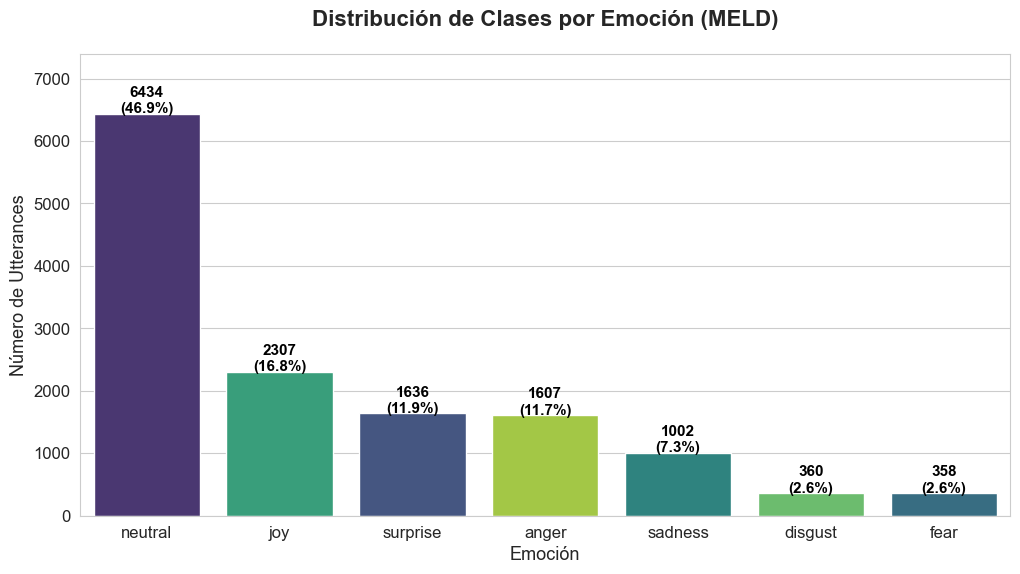

In [ ]:
# Configuración de estilo 
sns.set_style("whitegrid") # se configura el estilo visual de Seaborn con fondo blanco y rejilla
plt.rcParams.update({'font.size': 12}) # se actualiza el tamaño por defecto de la fuente en Matplotlib

# --- 1. CONTEO DE EMOTION (GRÁFICO DE BARRAS) ---

plt.figure(figsize=(12, 6))

# Calculamos el orden de mayor a menor
order_list = df_meld['Emotion'].value_counts().index

# ------ 2. Creación del gráfico -----------
ax = sns.countplot(data=df_meld, 
                   x='Emotion', 
                   hue="Emotion", # se usa la variable objetivo como hue para evitar la advertencia de Seaborn
                   legend = False, 
                   order=order_list, 
                   palette='viridis')

plt.title('Distribución de Clases por Emoción (MELD)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoción', fontsize=13)
plt.ylabel('Número de Utterances', fontsize=13)

# Se añade en el gráfico el número y el % 
total = len(df_meld) # número total de registros del dataset
for p in ax.patches: # Se recorre cada una de las barras de nuestro gráfico
    height = p.get_height() # De cada barra se extrae la altura de la misma
    percentage = '{:.1f}%'.format(100 * height / total)  # Altura/Total x 100 --> Indica en porcentaje la altura de la barra
    ax.text(p.get_x() + p.get_width() / 2., height + 15, # Se indica la posición en la que queremos que se muestre visualmente el valor
            f'{int(height)}\n({percentage})', # Texto que queremos que se muestre
            ha="center", fontsize=11, color='black', fontweight='bold')

# Ajustamos los márgenes
plt.ylim(0, df_meld['Emotion'].value_counts().max() * 1.15) # Se deja un 15% de margen superior en el gráfico

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_4_1_EDA_MELD_DistribucionEmociones.png'), dpi=300)

plt.show()



Visualmente, la distribución se asemeja a una estructura de 'Cola Larga' (Long Tail), donde la **cabeza** se encuentra en la clase **neutral**, que domina con respecto al resto de clases en el dataset con un **46.9%** de instacias que la presentan. El **cuerpo** lo definen las emociones de **joy**, **surprise**, **anger**, con una representación media (las 3 en su conjunto alcanzan aproximadamente un 40% de presencia en el dataset). Y por último, la **cola** (*tail*), compuesta por las emociones de **sadness**, **disgust** y **fear**, que caen drásticamente. Podemos fijarnos que **fear** (miedo), que es parte de nuestro **Target** de estrés, está al final de la cola, con solo un 2.6%. En términos técnicos, estamos ante un problema de **Desbalanceo de Clases**.

La **cola** de la distribución (*Sadness*, *Disgust*, *Fear*) contiene precisamente las clases minoritarias que componen nuestra variable objetivo. Esto confirma que el principal reto del *dataset* no es solo la variabilidad, sino la escasez de muestras positivas para el entrenamiento.

##### 1.2. Distribución de la Clase Objetivo (**target_stress**) y Desbalanceo.

A continuación, se analiza el desbalanceo existente en el conjunto de datos con respecto a la variable objetivo **target_stress** a través de un **Pie Chart**.

**** ESTADÍSTICAS DE DESBALANCEO ***
Total Muestras: 13704
Clase 0 (No Estrés): 11739
Clase 1 (Estrés): 1965
Ratio de Desbalanceo (IR): 1:5.97


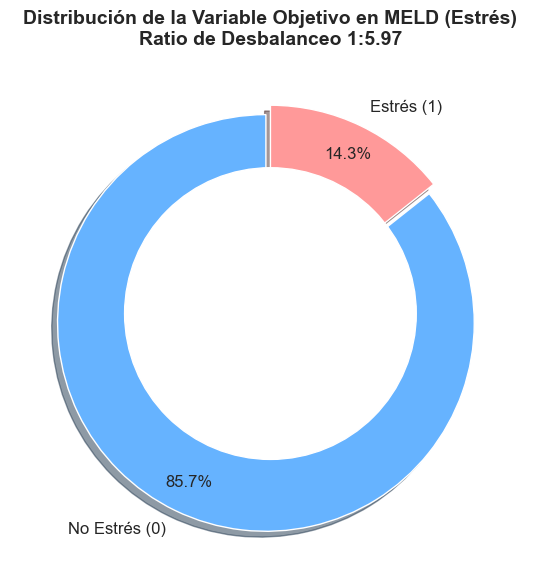

In [ ]:
conteo = df_meld['target_stress'].value_counts()
etiquetas = ['No Estrés (0)', 'Estrés (1)']
colores = ['#66b3ff', '#ff9999'] # Indicamos con color azul para No Estrés y color rojo para Estrés

# Se calcula el Ratio de Desbalanceo (Imbalance Ratio - IR)
n_neg = conteo[0]# Número de No Estrés (instancias negativas)
n_pos = conteo[1] # Número de Estrés (instancias positivas)
ratio = n_neg / n_pos # Ratio de Desbalanceo

print(f"**** ESTADÍSTICAS DE DESBALANCEO ***")
print(f"Total Muestras: {len(df_meld)}")
print(f"Clase 0 (No Estrés): {n_neg}")
print(f"Clase 1 (Estrés): {n_pos}")
print(f"Ratio de Desbalanceo (IR): 1:{ratio:.2f}")

# Gráfico de Donut
plt.figure(figsize=(8, 6))

plt.pie(conteo, # variable que determina el tamaño de cada sector de nuestro gráfico circular
        labels=etiquetas, # etiquetadas asociadas a cada sector del gráfico
        colors=colores, # colores utilizados por cada sector (azul y rojo)
        autopct='%1.1f%%', # formato del texto para mostrar automáticamente el porcentaje que corresponde a cada sector, mostrándolo con un único decimal
        startangle=90, # ángulo desde el cual comienza a dibujarse el primer sector (con 90 estamos indicando que queremos que el gráfico empiece desde la parte superior)
        pctdistance=0.85, # distancia radial a la que se colocan los porcentajes respecto al centro del gráfico
        explode=(0.05, 0),  #separación radial de cada sector respecto al centro, donde el primer sector se desplaza ligeramente para resaltarlo
        shadow=True) # se añade una pequeña sombra al gráfico para dar sensación de profundidad

centre_circle = plt.Circle((0,0), 0.70, fc='white') # creamos el centro en blanco para completar nuestro Gráfico de Donut
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title(f'Distribución de la Variable Objetivo en MELD (Estrés)\nRatio de Desbalanceo 1:{ratio:.2f}', fontsize=14, fontweight='bold')
plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_4_2_EDA_MELD_PieChartEstres.png'), dpi=300)
plt.show()

Un total de **11739** instancias del total (**13704**) son etiquetadas como **No Estrés** (instancias negativas), frente a un total de **1965** instancias positivas (**Estrés**), confirmando el claro desajuste entre ambas clases.

El **Ratio de Desbalanceo** obtenido de **1: 5.97** nos está indicando literalmente, que por cada **vídeo** etiquetado como **estrés**, tenemos casi **6 vídeos** etiquetados **sin estrés**.\
Esto representa una clara desventaja crítica para la tarea de detección de estrés: sin medidas correctivas, el modelo desarrollará un fuerte sesgo hacia la clase mayoritaria (prediciendo siempre **'no-estrés'** para maximizar la exactitud o *Accuracy*), lo que le impedirá generalizar y detectar correctamente los casos positivos de estrés (bajo *Recall*).

#### **2. Análisis de la Estructura del Diálogo.**

##### 2.1. Conteo de Utterance_ID por Dialogue_ID (Histograma Discreto con Curva de Densidad KDE).

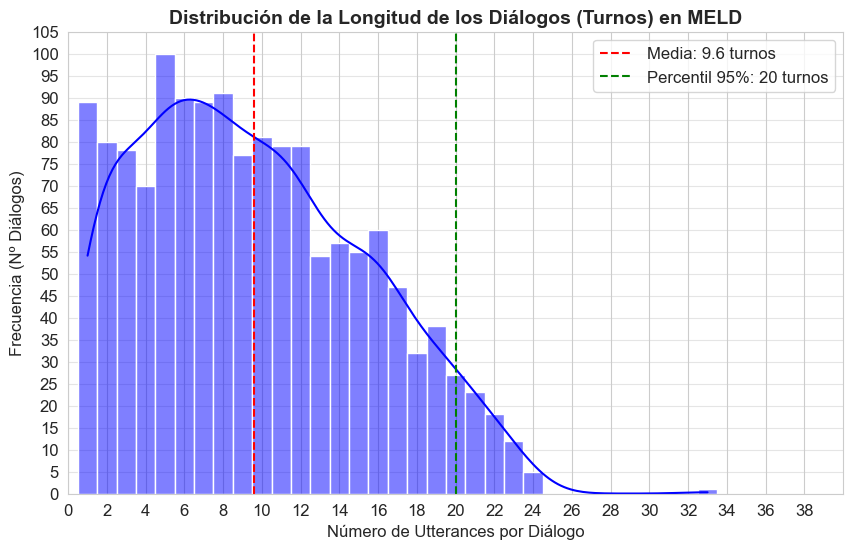

**** ESTADÍSTICAS DE PROFUNDIDAD DE DIÁLOGO ****
Longitud Mínima: 1 turnos
Longitud Máxima: 33 turnos
Si cortamos en 20 turnos, cubrimos el 95% de los casos.


In [ ]:
# --- ANÁLISIS DE LA ESTRUCTURA DEL DIÁLOGO (LONGITUD) ---

# 1. Calculamos cuántos utterances tiene cada diálogo
# Debido a las colisiones detectadas anteriormente con Dialogue_ID + Utterance_ID, se agrupa en función de Dialogue_ID + Split, para evitar sumar diálogos con el mismo ID pero de particiones distintas
dialogue_lengths = df_meld.groupby(['split', 'Dialogue_ID'])['Utterance_ID'].count()

# 2. Histograma con curva de densidad (KDE)
plt.figure(figsize=(10, 6))
sns.histplot(dialogue_lengths,
             discrete=True, # Al ser una variable discreta, se establece una barra por cada valor
             kde=True, 
             color='blue',
             edgecolor='white')

# Para una mayor claridad, mostramos un número cada 2 unidades en el eje X, hasta el 40.
# Y en el eje Y, se indican también los números de 5 en 5 hasta el 110
plt.xticks(np.arange(0, 40, 2)) 
plt.yticks(np.arange(0, 110, 5))

# 3. Se añaden líneas verticales para la media y el percentil 95 
mean_len = dialogue_lengths.mean()
p95_len = dialogue_lengths.quantile(0.95)

plt.axvline(mean_len, color='red', linestyle='--', label=f'Media: {mean_len:.1f} turnos')
plt.axvline(p95_len, color='green', linestyle='--', label=f'Percentil 95%: {p95_len:.0f} turnos')


plt.title('Distribución de la Longitud de los Diálogos (Turnos) en MELD', fontsize=14, fontweight='bold')
plt.xlabel('Número de Utterances por Diálogo', fontsize=12)
plt.ylabel('Frecuencia (Nº Diálogos)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.xlim(0, 40)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_6_EDA_MELD_DistribucionUtterances.png'), dpi=300)

plt.show()

# Se muestra un resumen estadístico:
print(f"**** ESTADÍSTICAS DE PROFUNDIDAD DE DIÁLOGO ****")
print(f"Longitud Mínima: {dialogue_lengths.min()} turnos")
print(f"Longitud Máxima: {dialogue_lengths.max()} turnos")
print(f"Si cortamos en {int(p95_len)} turnos, cubrimos el 95% de los casos.")

El análisis visual de la distribución confirma la variabilidad en la duración de las interacciones en *Friends*. Se constata que la totalidad de los diálogos se compone de al menos **un turno** de habla (utterance), variando desde interacciones mínimas hasta conversaciones extensas de **33 turnos**.

Los datos revelan una clara distribución de **Cola Larga** (*Long Tail*), donde la **moda** (lo más frecuente) es que la inmensa mayoría de los diálogos son breves. Específicamente, **88 diálogos** constan de **una** única *utterance*, constituyendo al extremo inferior. Que siga esta distribución de **Cola Larga** no es casualidad, sino que está relacionado con la propia naturaleza del lenguaje humano y, sobre todo, de la televisión. Es muy raro que dos personas estén hablando 33 turnos seguidos sin que cambie la escena, pero puede pasar. Esos casos raros forman la "cola larga".

La **media aritmética** (representada con la línea roja) se sitúa en **9.6 turnos** por diálogo, y visualmente el descenso drástico comienza a partir de los **6-8 turnos**. Nuestro modelo, en promedio, tendrá que procesar unas 10 frases para entender el contexto de una escena.

Solo **un único** diálogo alcanza la longitud máxima de **33 turnos**.

La línea azul presente en el gráfico (**KDE**), representa la silueta sueva de la distribución. Nos ayuda a visualizar de forma general los datos sin el *'ruido'* de las barras.

La **conclusión** es que la gran mayoría de los diálogos o escenas en MELD son cortas, rápidas y tipo "sitcom" (chiste, respuesta, risas, corte).

*Decisión de Diseño (Context Window)*: Se establece el percentil 95 (**20 turnos**) como punto de corte (cutoff). Esto indica que el 95% de las conversaciones tienen menos de 20 turnos. Esta estrategia es óptima puesto que captura la integridad del núcleo conversacional y la gran mayoría de los desarrollos medios, descartando únicamente la información redundante de los outliers extremos.\
Esto definirá la dimensión de entrada del modelo (max_seq_len = 20). Durante la fase de carga de datos (Data Loader), se aplicarán dos mecanismos de estandarización:
* **Relleno (Padding)**: A los diálogos con menos de 20 turnos se les añadirán valores neutros (ceros) hasta alcanzar la longitud fija.
* **Truncamiento**: A los diálogos que excedan este límite (como el caso extremo de 33 turnos) se les recortará el exceso, conservando los 20 turnos más relevantes para la predicción.

#### **3. Análisis Textual (NLP).**

##### 3.1. Distribución de Longitud Textual (Word Count). Histograma Discreto con Curva de Densidad KDE.

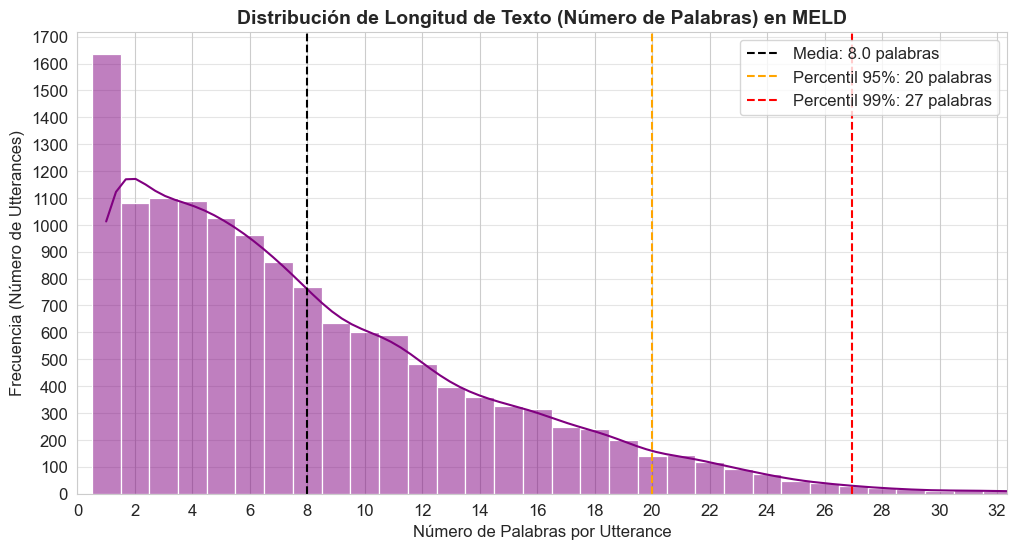


*** ESTADÍSTICAS DE LONGITUD (TOKENIZACIÓN)***
Longitud Mínima: 1 palabras
Longitud Máxima: 69 palabras
Media: 8.01 palabras
Percentil 95%: 20 palabras
Percentil 99%: 27 palabras


In [ ]:
# 1. Gráfico de Distribución (Histograma + KDE)
plt.figure(figsize=(12, 6))
sns.histplot(df_meld['word_count'], 
             discrete=True, 
             kde=True, 
             color='purple')

plt.xticks(np.arange(0, 50, 2)) 
plt.yticks(np.arange(0, 1800, 100))

# 2. Líneas de referencia (Decisión de Diseño de max_length)
mean_words = df_meld['word_count'].mean()
p95_words = df_meld['word_count'].quantile(0.95)
p99_words = df_meld['word_count'].quantile(0.99)
max_words = df_meld['word_count'].max()

plt.axvline(mean_words, color='black', linestyle='--', label=f'Media: {mean_words:.1f} palabras')
plt.axvline(p95_words, color='orange', linestyle='--', label=f'Percentil 95%: {p95_words:.0f} palabras')
plt.axvline(p99_words, color='red', linestyle='--', label=f'Percentil 99%: {p99_words:.0f} palabras')

plt.title('Distribución de Longitud de Texto (Número de Palabras) en MELD', fontsize=14, fontweight='bold')
plt.xlabel('Número de Palabras por Utterance', fontsize=12)
plt.ylabel('Frecuencia (Número de Utterances)', fontsize=12)
plt.legend()
plt.xlim(0, p99_words * 1.2) # Cortamos el eje X un poco después del 99% para mostrarlo mucho mejor
plt.grid(axis='y', alpha=0.5)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_7_1_EDA_MELD_DistribucionTexto.png'), dpi=300)

plt.show()

# 3. Resumen de las stadísticas descriptivas 
print(f"\n*** ESTADÍSTICAS DE LONGITUD (TOKENIZACIÓN)***")
print(f"Longitud Mínima: {df_meld['word_count'].min()} palabras")
print(f"Longitud Máxima: {max_words} palabras")
print(f"Media: {mean_words:.2f} palabras")
print(f"Percentil 95%: {p95_words:.0f} palabras")
print(f"Percentil 99%: {p99_words:.0f} palabras")

Similar al gráfico anterior, en este caso se presenta la distribución del número de palabras por cada **utterance** o **turno**. Al menos todos los turnos presentan **1 palabra**, y hay **turnos** que presentan como máximo **69** palabras. La media de **palabras** por turno es de aproximadamente **8** palabras. El **95%** de las utterances presentan hasta **20 palabras**, y el **99%** presentan hasta **27 palabras**.

También, visualmente, se aprecia esa distribución de **Cola Larga** ya mencionada, también conocida técnicamente como Asimetría Positiva (predominan los valores bajos).

*Decisión de Diseño (Tokenización)*: Estos hallazgos son determinantes para establecer el hiperparámetro de longitud máxima de secuencia (max_length) en el tokenizador del modelo de NLP. Basándonos en el percentil 99, se establecerá un corte (o padding) en torno a 30-32 tokens. Esta longitud es suficiente para capturar la totalidad de la información semántica en el 99% de los casos, evitando el desperdicio computacional que supondría dimensionar la entrada para el caso extremo de 69 palabras.

##### 3.2. Análisis Semántico: Nube de Palabras (Wordcloud) para ESTRÉS y NO ESTRÉS.

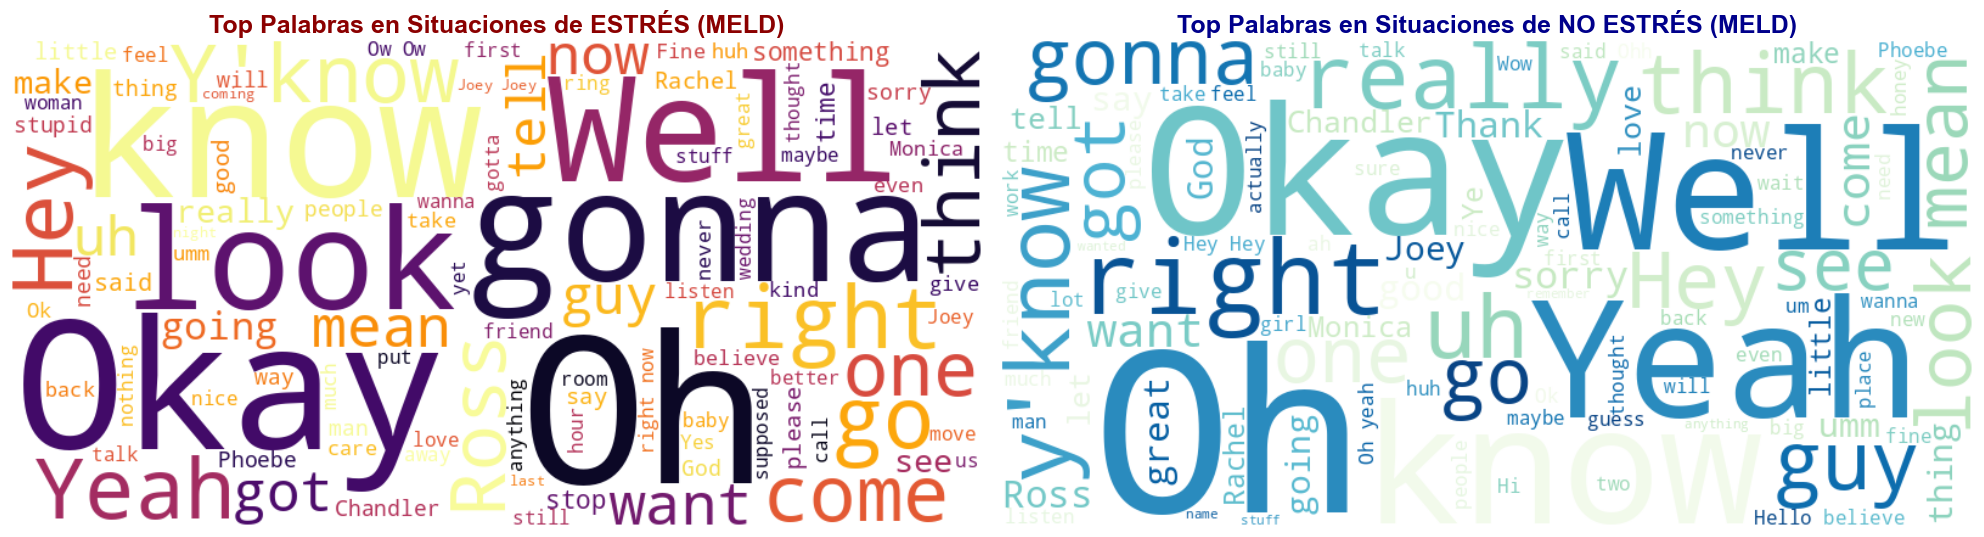

In [ ]:
# 1. Preparación del Texto
# Juntamos todas las frases de Estrés (1) en un solo texto 
text_stress = " ".join(df_meld[df_meld['target_stress'] == 1]['Utterance'].astype(str))

# Juntamos todas las frases de No-Estrés (0) en otro texto 
text_no_stress = " ".join(df_meld[df_meld['target_stress'] == 0]['Utterance'].astype(str))

# Definimos "Stopwords" (palabras vacías como 'the', 'a', 'is' que no aportan significado)
stopwords_set = set(STOPWORDS)

# 2. Configuración de la visualización
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # Establecemos 2 subplots

# --- NUBE 1: ESTRÉS (Usamos colores "calientes") ---
wc_stress = WordCloud(background_color='white', stopwords=stopwords_set, 
                      max_words=100, width=800, height=400, colormap='inferno').generate(text_stress)

axes[0].imshow(wc_stress, interpolation='bilinear')
axes[0].set_title('Top Palabras en Situaciones de ESTRÉS (MELD)', fontsize=18, fontweight='bold', color='darkred')
axes[0].axis('off')

# --- NUBE 2: NO ESTRÉS (Usamos colores "fríos") ---
wc_no_stress = WordCloud(background_color='white', stopwords=stopwords_set, 
                         max_words=100, width=800, height=400, colormap='GnBu_r').generate(text_no_stress)

axes[1].imshow(wc_no_stress, interpolation='bilinear')
axes[1].set_title('Top Palabras en Situaciones de NO ESTRÉS (MELD)', fontsize=18, fontweight='bold', color='darkblue')
axes[1].axis('off')

plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_8_EDA_MELD_NubePalabrasEstres.png'), dpi=300)

plt.show()

Algo que nos llama la atención es la superposición (**Overlap**) que se encuentra en las palabras como *'Oh'*,*'Okay'*, *'know'*, *'gonna'*, *'Yeah'*, que se encuentran presentes en ambos dos conjuntos. Esto es una **trampa** del lenguaje. La gente dice *'Oh'* cuando está asustada (Estrés) y cuando está sorprendida felizmente (No Estrés). Dicen *'Okay'* para aceptar una orden de mala manera (Estrés) o para estar de acuerdo (No Estrés).

**Esto que se acabamos de esclarecer es clave para justificar nuestro proyecto**, ya que se demuestra que el **texto**, por sí solo, es **débil**. Si el modelo lee la palabra *'Okay'*, no tiene idea de si es estrés o no, porque la probabilidad sería 50/50. Necesitamos por tanto la multimodalidad (**audio** y **vídeo**) para decidir.

Algo curioso es que el nombre de Ross aparece bastante grande en la nube de **Estrés**, ya que se caracteriza por ser un personaje en la serie que siempre está metido en líos dramáticos.

#### **4. Consistencia Estadística de los Conjuntos (Data Splits). Gráfico de Barras Comparativo.**

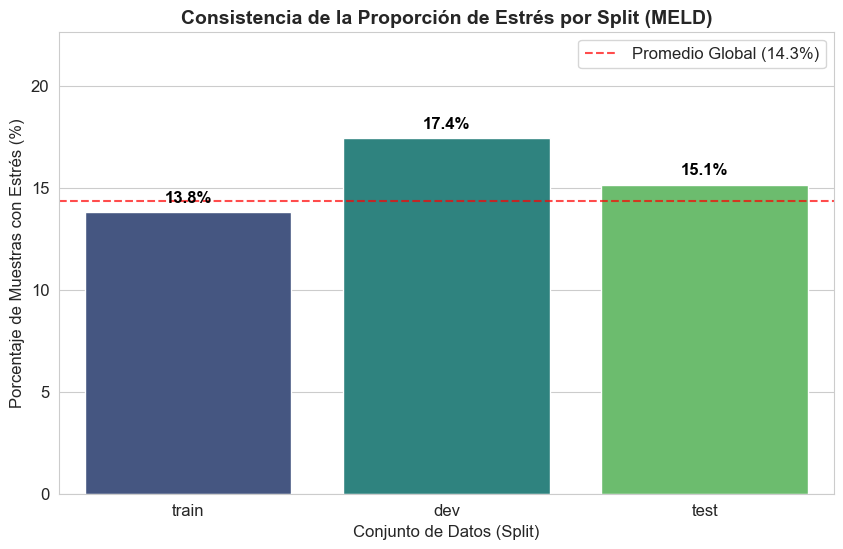

In [ ]:
# 1. Calculamos el % de Estrés en cada Split
# Agrupamos por 'split' y calculamos la media de 'target_stress' (que equivale al % al multiplicar por 100)
split_stats = df_meld.groupby('split')['target_stress'].mean() * 100
split_counts = df_meld['split'].value_counts()

# Definimos el orden para el gráfico
order_splits = ['train', 'dev', 'test']

# Reordenamos la serie para que coincida con el orden indicado
split_stats = split_stats.reindex(order_splits)

# 2. Gráfico de Comparación
plt.figure(figsize=(10, 6))

# Gráfico de barras
ax = sns.barplot(x=split_stats.index, 
                 hue = split_stats.index, 
                 legend=False, 
                 y=split_stats.values, 
                 palette='viridis', 
                 order=order_splits)

# Añadimos una línea global de referencia (indicando la media)
global_stress_rate = df_meld['target_stress'].mean() * 100
plt.axhline(global_stress_rate, color='red', linestyle='--', alpha=0.7, 
            label=f'Promedio Global ({global_stress_rate:.1f}%)')

plt.title('Consistencia de la Proporción de Estrés por Split (MELD)', fontsize=14, fontweight='bold')
plt.ylabel('Porcentaje de Muestras con Estrés (%)', fontsize=12)
plt.xlabel('Conjunto de Datos (Split)', fontsize=12)
plt.ylim(0, split_stats.max() * 1.3) # Dejamos un 30% de margen
plt.legend()

# 3. Etiquetamos cada barra con el porcentaje (altura)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5,
            f'{height:.1f}%',
            ha="center", fontsize=12, fontweight='bold', color='black')

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_5_EDA_MELD_ProporcionEstresSplit.png'), dpi=300)

plt.show()

Hay una gran estabilidad en las tres particiones en relación a la presencia de instancias positicas (**Estrés**). Las proporciones oscilan en un rango estrecho, desde un 13.8% en entrenamiento hasta un 17.4% en validación. Aunque el conjunto de validación (Dev) presenta una ligera sobrerrepresentación de casos positivos, la desviación no se considera crítica. 

El conjunto de test presenta un **15.1%** de muestras de estrés, situándose muy próximo al promedio global, lo que garantiza una evaluación representativa.

*Decisión Metodológica:* A pesar de las ligeras fluctuaciones, se toma la decisión de respetar estrictamente la división original de los autores. Esta estrategia es fundamental para garantizar la reproducibilidad y permitir una comparación justa (benchmarking) de los resultados obtenidos en este TFG con el Estado del Arte actual, dado que la literatura científica utiliza esta partición específica para reportar métricas de rendimiento.

### **BLOQUE II**: Análisis de Audio.

#### **1. Distribución Temporal de las Señales de Audio (Histograma Continuo de Duración de Audio).**

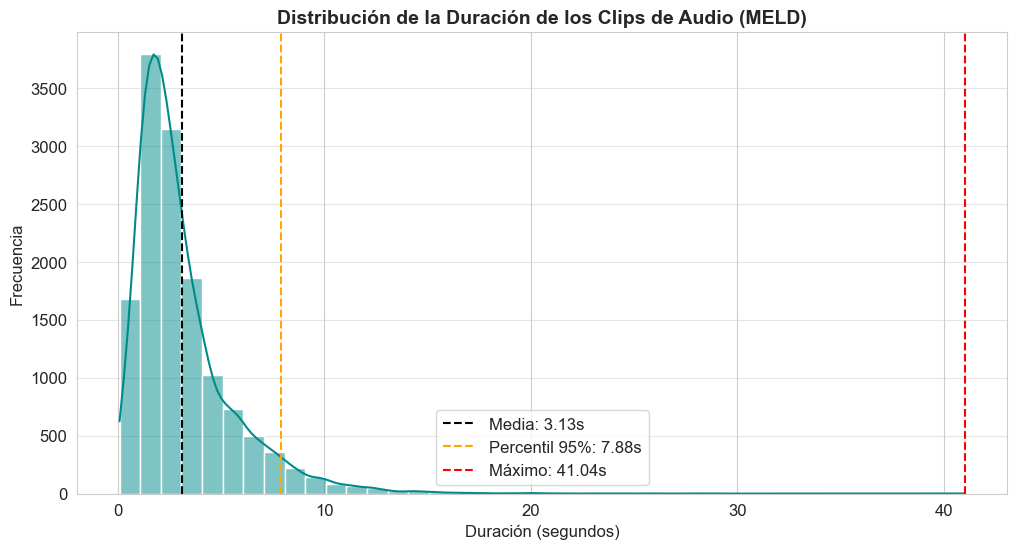

ESTADÍSTICAS DE AUDIO: 
Duración Mínima: 0.08 segundos
Duración Máxima: 41.04 segundos
Media: 3.13 segundos
Percentil 95%: 7.88 segundos
Percentil 99%: 11.64 segundos


In [ ]:
# En el preprocesamiento se obtuvo, como parte de la comprobación de la integridad de los vídeos y audios, la duración exacta del vídeo (audio), la utilizamos ahora para el gráfico:
durations = df_meld['duration']

plt.figure(figsize=(12, 6))
sns.histplot(durations, 
             binwidth=1,  # cada barra = 1 segundo
             kde=True, 
             color='darkcyan')

# 4. Líneas de referencia (Padding/Truncation)
mean_dur = durations.mean()
max_dur = durations.max()
p95_dur = durations.quantile(0.95)
p99_dur = durations.quantile(0.99)

plt.axvline(mean_dur, color='black', linestyle='--', label=f'Media: {mean_dur:.2f}s')
plt.axvline(p95_dur, color='orange', linestyle='--', label=f'Percentil 95%: {p95_dur:.2f}s')
plt.axvline(max_dur, color='red', linestyle='--', label=f'Máximo: {max_dur:.2f}s')

plt.title('Distribución de la Duración de los Clips de Audio (MELD)', fontsize=14, fontweight='bold')
plt.xlabel('Duración (segundos)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_9_1_EDA_MELD_DistribucionDuracionAudio.png'), dpi=300)

plt.show()

# 5. Resumen Estadístico
print(f"ESTADÍSTICAS DE AUDIO: ")
print(f"Duración Mínima: {durations.min():.2f} segundos")
print(f"Duración Máxima: {durations.max():.2f} segundos")
print(f"Media: {mean_dur:.2f} segundos")
print(f"Percentil 95%: {p95_dur:.2f} segundos")
print(f"Percentil 99%: {p99_dur:.2f} segundos")

El histograma revela una distribución con una asimetría positiva extrema (la mayoría de valores son muy bajos), debido a que la duración media de las intervenciones es de apenas **3.13** segundos, lo cual es coherente con la naturaleza de *sitcom* de ritmo rápido de la serie *Friends*.

Se ha detectado un valor máximo anómalo de **41.04** segundos, pero no se trata de un *outlier extremo* como en el caso de los vídeos tratados en el preprocesamiento (de entre **200** y **300** segundos de duración), que estos sí se eliminaron ya que se trataban de errores.

Como era de esperar, también la distribución de la duración de los audios (vídeos) sigue una distribución de **Cola Larga**, en donde predominan los valores bajos.

*Decisión de Diseño (Audio Padding/Truncation)*: Dimensionar la entrada del modelo acústico basándose en el máximo (**41s**) sería computacionalmente ineficiente, ya que implicaría que la mayoría de los tensores estarían compuestos de padding (ceros).\
Por esto, se establece una ventana temporal máxima operativa de 12 segundos (coincidente con el Percentil 99), de acuerdo a los resultados obtenidos con este *dataset* en concreto.

Por tanto, todos los audios superiores a 12s serán truncados, y los inferiores serán rellenados (padded). Esta decisión garantiza que cubrimos la integridad del audio en el 99% de las muestras, optimizando drásticamente el uso de memoria GPU y acelerando el entrenamiento sin pérdida significativa de información.

### **BLOQUE III**: Análisis de Vídeo.

#### **1. Muestreo Aleatorio de Frames (Grid de Imágenes).**

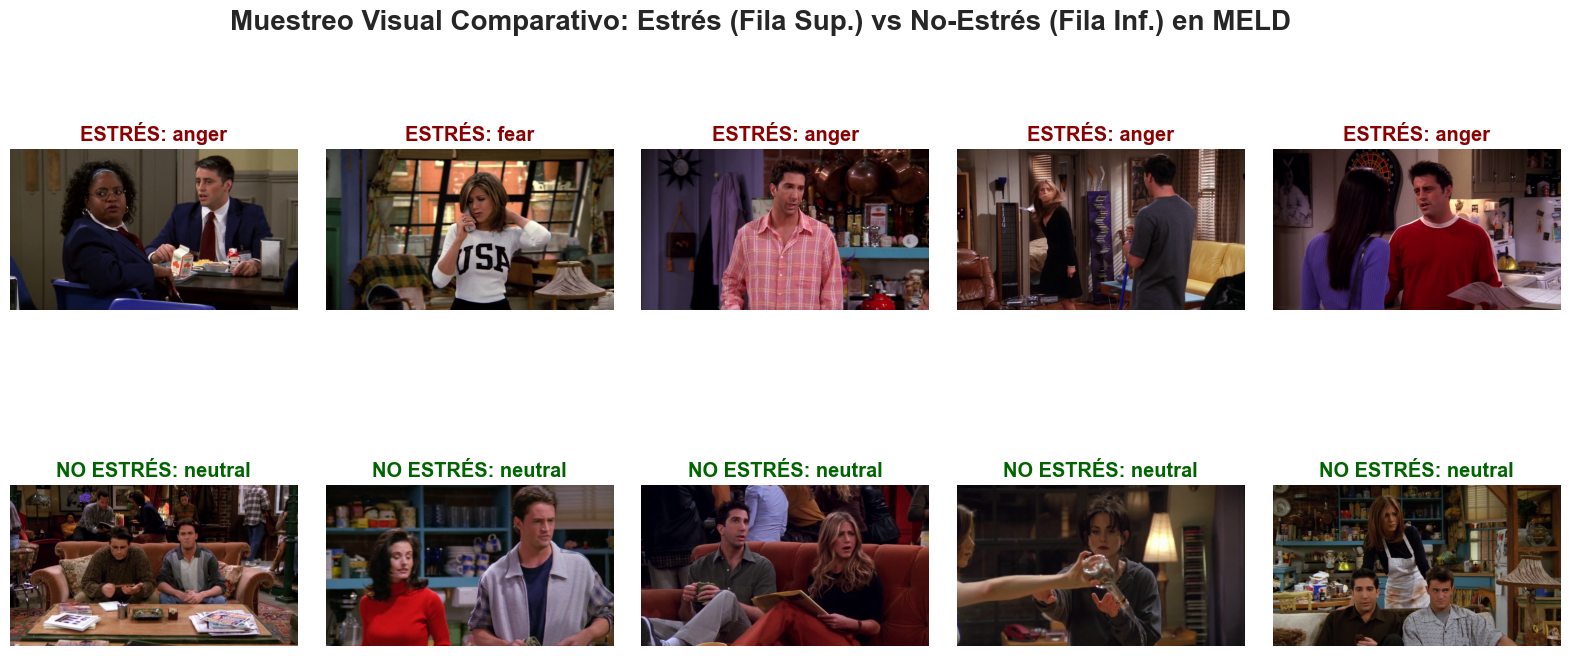

In [ ]:
# 1. Función para extraer un frame del medio del vídeo
def extract_frame(video_path):
    """
    Función que extrae un frame (captura) del vídeo. 
    Específicamente, extrae el frame en la mitad del vídeo
    """
    cap = cv2.VideoCapture(video_path) # en el paquete de cv2 se incluye la clase VideoCapture, que crea un objeto (cap) a raíz del vídeo, el cual tiene métodos asociados
    
    if not cap.isOpened():
        print(f"No se pudo abrir el archivo de vídeo: {video_path}")
        return None

    # Vamos al fotograma del medio para evitar pantallas negras de inicio
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # extraemos el número total de frames del vídeo
    middle_frame = max(0, total_frames // 2) # nos vamos justo al frame a la mitad del vídeo
    cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame)
    
    ret, frame = cap.read() # Extraemos el frame seleccionado en en el cual nos hemos posicionado
    cap.release()
    
    if ret:
        # Convertimos de BGR (OpenCV) a RGB (Matplotlib)
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

# 2. Seleccionamos muestras aleatorias
# Cogemos 5 de estrés (valor 1) y 5 de no estrés (valor 0)
n_samples = 5
stress_samples = df_meld[df_meld['target_stress'] == 1].sample(n_samples, random_state=42)
no_stress_samples = df_meld[df_meld['target_stress'] == 0].sample(n_samples, random_state=42)

# 3. Creamos el Grid 
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # Establecemos 5 subplots en dos filas (total de 10)
plt.subplots_adjust(wspace=0.1, hspace=0.2) 

# Fila 1: ESTRÉS
for i, (_, row) in enumerate(stress_samples.iterrows()):
    frame = extract_frame(os.path.join(MELD_VIDEO_PATH, row['video_path']))
    ax = axes[0, i] # En la primer fila se muestran los frames de aquellos vídeos etiquetados como "Estrés"
    if frame is not None:
        ax.imshow(frame) # Mostramos el frame en el subplot en cuestión
        ax.set_title(f"ESTRÉS: {row['Emotion']}", color='darkred', fontweight='bold')
    else:
        ax.text(0.5, 0.5, "Error lectura", ha='center') # En tal caso que no se pueda mostrar el frame, se muestra un error en el subplot
    ax.axis('off')

# Fila 2: NO ESTRÉS 
for i, (_, row) in enumerate(no_stress_samples.iterrows()):
    frame = extract_frame(os.path.join(MELD_VIDEO_PATH, row['video_path']))
    ax = axes[1, i] # En la segunda fila se muestran los frames de aquellos vídeos etiquetados como "No Estrés"
    if frame is not None:
        ax.imshow(frame)
        ax.set_title(f"NO ESTRÉS: {row['Emotion']}", color='darkgreen', fontweight='bold')
    else:
        ax.text(0.5, 0.5, "Error lectura", ha='center')
    ax.axis('off')

plt.suptitle('Muestreo Visual Comparativo: Estrés (Fila Sup.) vs No-Estrés (Fila Inf.) en MELD', fontsize=20, fontweight='bold')

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_10_EDA_MELD_MuestreoVisual.png'), dpi=300)

plt.show()

Con este muestreo realizado podemos observar a simple vista, además de la calidad de las imágenes en el vídeo, también las expresiones faciales de los actores, para determinar caras de ira o miedo (**Estrés**) frente a caras que representan otras emociones como tristeza, alegría, sorpresa o neutral.

Por ejemplo, en la tercera imagen de la segunda fila, podemos observar a Ross y Rachel con una expresión de asombro, la cual podríamos pensar que en lugar de ser una emoción "neutra", podría ser de "sorpresa", aunque nos faltaría conocer el contexto de la escena (audio/texto). Además, hay que tener en cuenta que los autores de este dataset confirman en su artículo que hubo bastantes discrepancias a la hora del etiquetado. 

Pero en la mayoría de imágenes mostradas de los vídeos etiquetados como **No Estrés**, vemos que se muestran caras relajadas, neutras, mientras que, por ejemplo, en las de **Estrés**, en la primera imagen ya podemos observar caras de enfado o irritabilidad.

### **BLOQUE IV**: Análisis Bivariante y Detección de Sesgos.

#### **1. Correlación Texto-Estrés (Longitud). Boxplot.**

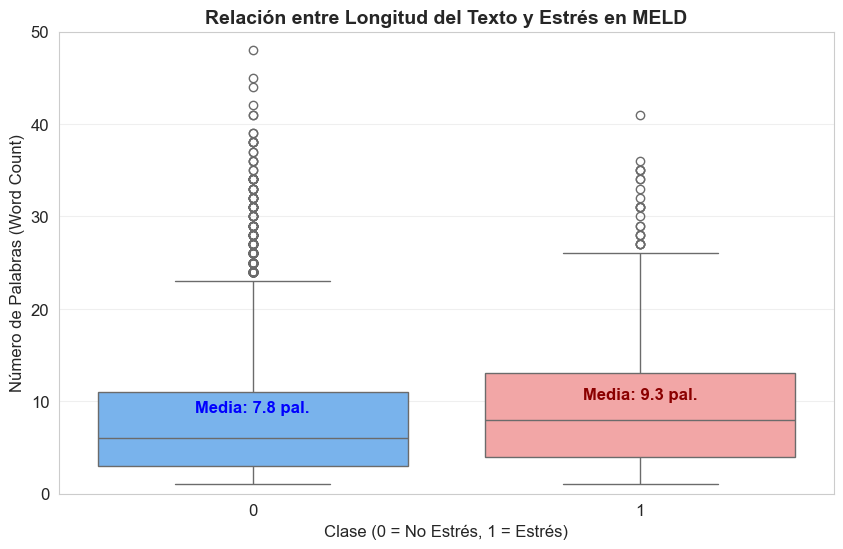

COMPARAMOS LA LONGITUD DE TEXTO:
Longitud Media (NO ESTRÉS):  7.80 palabras
Longitud Media (ESTRÉS): 9.26 palabras
Diferencia: 1.46 palabras


In [ ]:
# 1. Creamos el Boxplot
# Con este boxplot se muestra la Mediana (línea central), los Cuartiles (la caja) y los Outliers (puntos)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_meld, 
                 x = 'target_stress',
                 hue='target_stress', 
                 legend=False,
                 y='word_count', 
                 palette={0: '#66b3ff', 1: '#ff9999'}) # Azul y Rojo asignados a la variable objetivo

plt.title('Relación entre Longitud del Texto y Estrés en MELD', fontsize=14, fontweight='bold')
plt.xlabel('Clase (0 = No Estrés, 1 = Estrés)', fontsize=12)
plt.ylabel('Número de Palabras (Word Count)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 2. Se calculan las Medias para mostrar este dato también en el gráfico 
media_no_estres = df_meld[df_meld['target_stress'] == 0]['word_count'].mean()
media_estres = df_meld[df_meld['target_stress'] == 1]['word_count'].mean()

# Colocamos el dato de la media en la caja, para facilitar la comprensión
plt.text(0, media_no_estres + 1, f'Media: {media_no_estres:.1f} pal.', ha='center', fontweight='bold', color='blue')
plt.text(1, media_estres + 1, f'Media: {media_estres:.1f} pal.', ha='center', fontweight='bold', color='darkred')

# Limitamos el eje Y para ver mejor las cajas (cortamos los outliers extremos visualmente)
plt.ylim(0, 50) 

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_7_2_EDA_MELD_RelacionTextoEstres.png'), dpi=300)

plt.show()

# 3. Resumen Estadístico
print(f"COMPARAMOS LA LONGITUD DE TEXTO:")
print(f"Longitud Media (NO ESTRÉS):  {media_no_estres:.2f} palabras")
print(f"Longitud Media (ESTRÉS): {media_estres:.2f} palabras")
diferencia = media_estres - media_no_estres
print(f"Diferencia: {diferencia:.2f} palabras")

Al igual que vimos en el **histograma de duración de audio** y el **histograma de longitud de texto**, la gran mayoría de las muestras (tanto de estrés como no estrés) se concentran en valores bajos. Esto confirma que el dataset se compone principalmente de interacciones cortas (frases rápidas tipo sitcom). 

Para las instancias etiquetadas como **No Estrés**, al presentar una media de **7.8 palabras** (**1.46 palabras** menos que en los textos presentes en las instancias de **Estrés**), estas tienden a ser más breves. 

La **conclusión preliminar** es que, aunque la diferencia no es masiva, existe una tendencia visible: las intervenciones etiquetadas como estrés son ligeramente más largas y tienen mayor variabilidad (la caja roja es más grande), lo que sugiere que las situaciones de conflicto o tensión en la serie requieren un poco más de elaboración verbal que las interacciones casuales.

La presencia de múltiples **outliers** indica la presencia de esa distribución de **Cola Larga** ya mencionada, con muy pocas instancias que presentan una mayor longitud del texto, y la **masa global** (caja) de instancias presentan valores bajos.

#### **2. Correlación Audio-Estrés (Duración). Boxplot.**

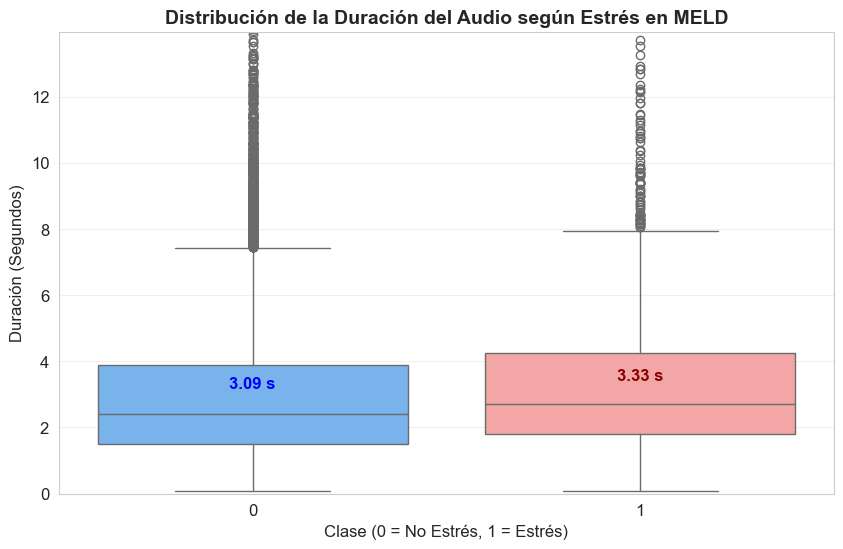

ANÁLISIS TEMPORAL: 
Duración Media (NO ESTRÉS):  3.09 segundos
Duración Media (ESTRÉS): 3.33 segundos
Diferencia: 0.23 segundos


In [ ]:
# 1. Boxplot: Duración por clase
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_meld, 
                 x='target_stress',
                 hue='target_stress', 
                 legend=False,
                 y='duration', 
                 palette={0: '#66b3ff', 1: '#ff9999'})

plt.title('Distribución de la Duración del Audio según Estrés en MELD', fontsize=14, fontweight='bold')
plt.xlabel('Clase (0 = No Estrés, 1 = Estrés)', fontsize=12)
plt.ylabel('Duración (Segundos)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 2. Calculamos y mostrar las medias (igual que el gráfico anterior, pero en este caso con la duración)
media_no_estres_dur = df_meld[df_meld['target_stress'] == 0]['duration'].mean()
media_estres_dur = df_meld[df_meld['target_stress'] == 1]['duration'].mean()

# Escribimos las medias en el gráfico
# Ajustamos la altura del texto (y) un poco por encima de la media para que se lea
plt.text(0, media_no_estres_dur + 0.1, f'{media_no_estres_dur:.2f} s', ha='center', fontweight='bold', color='blue')
plt.text(1, media_estres_dur + 0.1, f'{media_estres_dur:.2f} s', ha='center', fontweight='bold', color='darkred')

# Limitamos visualmente el eje Y si hay algún audio de 30 minutos que rompa la escala
# Usamos el percentil 99 que calculamos antes como límite lógico + un margen
limite_visual = df_meld['duration'].quantile(0.99) * 1.2
plt.ylim(0, limite_visual)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_9_2_EDA_MELD_RelacionAudioEstres.png'), dpi=300)

plt.show()

# 4. Resumen estadístico
print(f"ANÁLISIS TEMPORAL: ")
print(f"Duración Media (NO ESTRÉS):  {media_no_estres_dur:.2f} segundos")
print(f"Duración Media (ESTRÉS): {media_estres_dur:.2f} segundos")
diff = media_estres_dur - media_no_estres_dur
print(f"Diferencia: {diff:.2f} segundos")

Alineado con las conclusiones extraídas del anterior punto, aquí obtenemos algo similar, pero esta vez con la duración del audio. Esto nos indica algo interesante en el análisis multimodal:

* En **Texto**, vimos que las frases de estrés cuentan con **+1.5** palabras de media.
* En **Audio**, vemos ahora que la diferencia de tiempo es minúscula (**+0.23** segundos).

A diferencia del texto, donde la separación era más visible, aquí las cajas de **Estrés** (1) y **No Estrés** (0) son casi idénticas en posición y tamaño.

Por tanto, se revela que, si decimos más palabras en casi el mismo tiempo, significa que la velocidad de habla (Speech Rate) aumenta. Conclusión: la gente estresada habla más rápido. El modelo podría aprender a detectar esta "aceleración" más que la duración en sí misma, es algo muy interesante a tener en cuenta.

**Outliers (Cola Larga)**: Se confirma visualmente la distribución de *Long Tail* detectada en el histograma general. Ambas clases presentan numerosos outliers superiores a 10-12 segundos, pero la "masa" de datos está comprimida abajo.

#### **3. Análisis de Sesgo de Interlocutor (Speaker Bias). Gráfico de Barras Apiladas.**

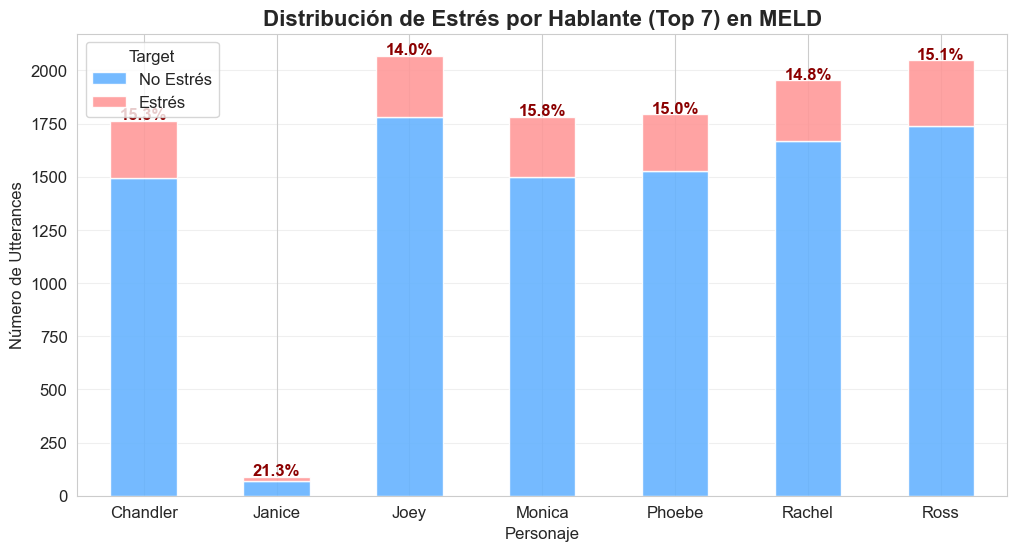

RANKING DE 'IRRITABILIDAD' (Riesgo de Sesgo, en %): 
Speaker
Janice      21.348315
Monica      15.768799
Chandler    15.258083
Ross        15.136719
Phoebe      14.986072
Rachel      14.782609
Joey        13.968101
Name: target_stress, dtype: float64


In [20]:
# 1. Filtramos los Top Speakers (seleccionamos los 6 protagonistas de Friends y algún secundario (camareros, extras))
top_n = 7 
top_speakers = df_meld['Speaker'].value_counts().nlargest(top_n).index

# Creamos un dataframe solo con los top speakers
df_top_speakers = df_meld[df_meld['Speaker'].isin(top_speakers)]

# 2. Tabla de Contingencia (Crosstab)
# Esta tabla de contingencia lo que hace es cruzar estas dos variables categóricas 
# (nombre del hablante y variable objetivo de Estrés) e indicar cuántas veces aparece cada combinación 
# (respondeindo a cuántas veces cada personaje aparece en cada clase de estrés y no estrés)
ct = pd.crosstab(df_top_speakers['Speaker'], df_top_speakers['target_stress'])

# 3. Gráfico de Barras Apiladas (Stacked Bar Plot)
# Nos permite ver el volumen total (cuánto habla cada uno) y la proporción de rojo (estrés), además de la proporción de instancias negativas (No Estrés) en las que están presentes
ax = ct.plot(kind='bar', 
             stacked=True, 
             figsize=(12, 6), 
             color=['#66b3ff', '#ff9999'], 
             alpha=0.9)

plt.title(f'Distribución de Estrés por Hablante (Top {top_n}) en MELD', fontsize=16, fontweight='bold')
plt.xlabel('Personaje', fontsize=12)
plt.ylabel('Número de Utterances', fontsize=12)
plt.legend(['No Estrés', 'Estrés'], title='Target')
plt.xticks(rotation=0) # Nombres rectos para leer mejor
plt.grid(axis='y', alpha=0.3)

# 5. Cálculo del % de Estrés por Personaje (La "Tasa de Irritabilidad")
# Se pretende con esto responder a la pregunta de quién es el más estresado (porcentualmente)
speaker_bias = df_top_speakers.groupby('Speaker')['target_stress'].mean() * 100
speaker_bias = speaker_bias.sort_values(ascending=False)

# Añadimos el % encima de cada barra
for i, speaker in enumerate(ct.index):
    y_pos = ct.loc[speaker].sum() + 5 # 5 unidades por encima de la barra (para facilitar la visualización)
    pct = speaker_bias[speaker]
    ax.text(i, y_pos, f'{pct:.1f}%', ha='center', fontweight='bold', color='darkred') 

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_11_EDA_MELD_SpeakerBias.png'), dpi=300)

plt.show()

# 6. Tabla Ranking 
print("RANKING DE 'IRRITABILIDAD' (Riesgo de Sesgo, en %): ")
print(speaker_bias)

Por cada personaje, se ha calculado el porcentaje de estrés relativo de la siguiente manera:
$$\text{Porcentaje de Estrés de Personaje X} = \left( \frac{\text{Nº Frases con Estrés del Personaje X}}{\text{Nº Total de Frases del Personaje X}} \right) \times 100$$

Por tanto, el gráfico de barras nos está mostrando la **Cantidad Absoluta** (cuánto hablan, barra completa azul + rojo), pero el número en rojo indica la **Intensidad Relativa** (cuánto de estresados son cuando hablan). Se observa que, aunque personajes secundarios como **Janice** tienen una participación total mucho menor (barra corta), presentan una tasa relativa de estrés superior (21.3%) a los protagonistas principales. Esto es que, aunque aparece pocas veces, cuando aparece, en el **21.3%** de sus apariciones se encuentra estresada.

**Conclusiones:** Los 6 protagonistas (Friends) presentan una distribución de estrés sorprendentemente equilibrada, oscilando en una intervalo muy estrecho entre el 14.0% (Joey) y el 15.8% (Monica). Esto es excelente para el entrenamiento. Garantiza que el modelo no asociará el estrés a la identidad vocal de un personaje específico (por ejemplo, no aprenderá que "Voz de Ross = Estrés"), sino que deberá buscar características acústicas reales. No se detecta un Speaker Bias grave. El riesgo de que el modelo haga overfitting sobre un hablante concreto es mínimo dado el equilibrio de las clases.

Y además, se revela algo curioso acerca de la personalidad de los personajes: **Monica** es la más estresada (frecuencia de **15.8%**), mientras que el más relajado es **Joey**.

#### **4. Matriz de Correlación.**

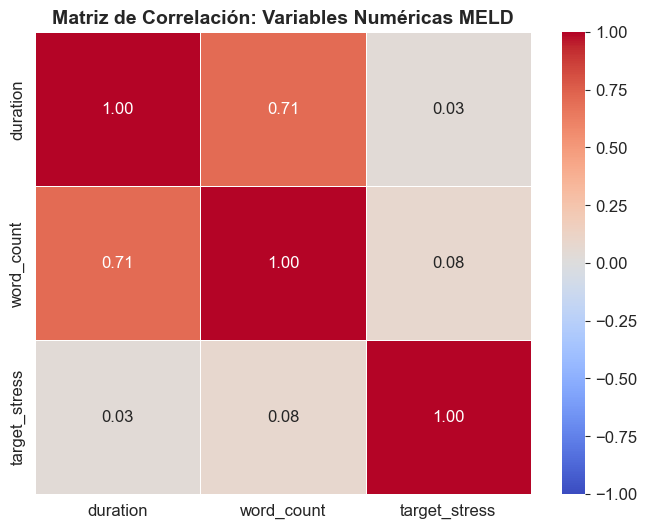

***** ANÁLISIS DE CORRELACIONES *****
Correlación Duración vs Palabras: 0.71
Correlación Estrés vs Duración: 0.03
Correlación Estrés vs Palabras: 0.08


In [21]:
# 1. Seleccionamos solo las columnas numéricas relevantes
# Excluimos los IDs
cols_corr = ['duration', 'word_count', 'target_stress']
df_corr = df_meld[cols_corr]

# 2. Calculamos la matriz de correlación (Método Pearson)
# 1.0 = Correlación total (si una sube, la otra sube igual)
# 0.0 = Sin relación
# -1.0 = Correlación inversa (si una sube, la otra baja)
corr_matrix = df_corr.corr()

# 3. Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True, # Para indicar los números dentro
            cmap='coolwarm',# Azul (frío) a Rojo (caliente)
            fmt=".2f",# Solo se indican 2 decimales
            linewidths=0.5,
            vmin=-1, vmax=1)  #Escala de -1 a 1

plt.title('Matriz de Correlación: Variables Numéricas MELD', fontsize=14, fontweight='bold')

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_12_EDA_MELD_MatrizCorrelacion.png'), dpi=300)

plt.show()

# 4. Interpretación 
print("***** ANÁLISIS DE CORRELACIONES *****")
dur_word_corr = corr_matrix.loc['duration', 'word_count']
stress_dur_corr = corr_matrix.loc['target_stress', 'duration']

print(f"Correlación Duración vs Palabras: {dur_word_corr:.2f}")
print(f"Correlación Estrés vs Duración: {stress_dur_corr:.2f}")
print(f"Correlación Estrés vs Palabras: {corr_matrix.loc['target_stress', 'word_count']:.2f}")

Con este último gráfico, lo que se pretende es analizar la relación entre las dos variables númericas obtenidas de las dos modalidades (texto -> **word_count**, vídeo/audio-> **duration**), del total de tres modalidades que presenta el dataset, con respecto a la variable objetivo de **Estrés** (**target_stress**) en este dataset **MELD**. 

* **Correlación Texto (Longitud) y Duración**: Con una correlación positiva alta de **0.71**, se puede decir que conforme más duración del vídeo/audio, más tiempo hablando, más palabras (mayor longitud del texto), pero el valor no es tan alto como se hubiera pensado obtener en un primer momento. Esto indica que la duración del clip no depende exclusivamente de lo que se dice. Al tratarse de una *sitcom*, factores como las risas del público, los silencios dramáticos y las reacciones no verbales influyen significativamente en el tiempo total. 
    * **Conclusión:** El audio aporta información temporal distinta al texto. No son redundantes.

* **Correlación Estrés y Duración**: Correlación positiva muy baja (de **0.03**), lo cual indica que no existe una correlación lineal directa. 
    * **Conclusión**: Un clip largo no implica necesariamente estrés.

* **Correlación Estrés y Texto (Longitud)**: Correlación positiva muy baja (de **0.08**), indicando también que no existe una correlación lineal directa. 
    * **Conclusión**: Una frase con muchas palabras no es necesariamente una discusión (estrés).

**Justificación Final del Deep Learning**: Dado que no hay una relación estadística simple (lineal), se confirma la necesidad de utilizar modelos complejos (Redes Neuronales, Transformers) capaces de detectar patrones no lineales (tono de voz, semántica, contexto) para predecir el estrés.
          

---

### **2. Análisis Dataset IEMOCAP (`IEMOCAP_clean`)**.

Para poder comparar con el corpus de **MELD**, se realizan a continuación las mismas pruebas clave, además de incluir otras específicas para este *dataset*, como, por ejemplo, analizar el *ratio* de instancias de **Estrés** en las muestras improvisadas frente a las guionizadas. 

In [23]:
# Carga de los datos ya preprocesados
file_path = IEMOCAP_CLEAN_CSV
if os.path.exists(file_path):
    df_iemocap = pd.read_csv(file_path)
    display(df_iemocap.head()) 
else:
    print(f"No se encuentra el archivo en {file_path}")

Utterance_ID  Session      Emotion  Valence  Arousal  Dominance  \
0  Ses01F_impro01_F000        1      neutral      2.5      2.5        2.5   
1  Ses01F_impro01_F001        1      neutral      2.5      2.5        2.5   
2  Ses01F_impro01_F002        1      neutral      2.5      2.5        2.5   
3  Ses01F_impro01_F005        1      neutral      2.5      3.5        2.0   
4  Ses01F_impro01_F006        1  frustration      2.0      3.5        3.5   

                                                Text  Start_Time  End_Time  \
0                                         Excuse me.      6.2901    8.2357   
1                                              Yeah.     10.0100   11.3925   
2                                Is there a problem?     14.8872   18.0175   
3         Well what's the problem? Let me change it.     27.4600   31.4900   
4  What? I'm getting an ID. This is why I'm here....     38.9650   43.5900   

                                      Path_Wav_Audio  \
0  Session1/sentences/wav/Ses01F_impro01/Ses01F_i...   
1  Session1/sentences/wav/Ses01F_impro01/Ses01F_i...   
2  Session1/sentences/wav/Ses01F_impro01/Ses01F_i...   
3  Session1/sentences/wav/Ses01F_impro01/Ses01F_i...   
4  Session1/sentences/wav/Ses01F_impro01/Ses01F_i...   

                    Path_Video_Processed  \
0  IEMOCAP_CLIPS/Ses01F_impro01_F000.mp4   
1  IEMOCAP_CLIPS/Ses01F_impro01_F001.mp4   
2  IEMOCAP_CLIPS/Ses01F_impro01_F002.mp4   
3  IEMOCAP_CLIPS/Ses01F_impro01_F005.mp4   
4  IEMOCAP_CLIPS/Ses01F_impro01_F006.mp4   

                             Path_Source_Video  duration     Dialogue_ID  \
0  Session1/dialog/avi/DivX/Ses01F_impro01.avi    1.9456  Ses01F_impro01   
1  Session1/dialog/avi/DivX/Ses01F_impro01.avi    1.3825  Ses01F_impro01   
2  Session1/dialog/avi/DivX/Ses01F_impro01.avi    3.1303  Ses01F_impro01   
3  Session1/dialog/avi/DivX/Ses01F_impro01.avi    4.0300  Ses01F_impro01   
4  Session1/dialog/avi/DivX/Ses01F_impro01.avi    4.6250  Ses01F_impro01   

   word_count  target_stress  
0           2              0  
1           1              0  
2           4              0  
3           8              0  
4          14              1

In [21]:
df_iemocap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7515 entries, 0 to 7514
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Utterance_ID          7515 non-null   object 
 1   Session               7515 non-null   int64  
 2   Emotion               7515 non-null   object 
 3   Valence               7515 non-null   float64
 4   Arousal               7515 non-null   float64
 5   Dominance             7515 non-null   float64
 6   Text                  7515 non-null   object 
 7   Start_Time            7515 non-null   float64
 8   End_Time              7515 non-null   float64
 9   Path_Wav_Audio        7515 non-null   object 
 10  Path_Video_Processed  7515 non-null   object 
 11  Path_Source_Video     7515 non-null   object 
 12  duration              7515 non-null   float64
 13  Dialogue_ID           7515 non-null   object 
 14  word_count            7515 non-null   int64  
 15  target_stress        

Se indica un total de **7515** registros en el dataset, con 16 variables: 9 de ellas numéricas (tres `int64` y seis `float64`), 7 de tipo categórico o textual (`object`), de las cuales **8 variables** (`Session`, `Path_Wav_Audio`, `Path_Video_Processed`, `Path_Source_Video`,`duration`, `Dialogue_ID`, `word_count`, `target_stress`) han sido obtenidas durante el preprocesamiento (ya sea por las hemos calculado o porque se han derivado de la estructura de directorios). En memoria ocupa un total de más de **939.5 KB**, aproximadamente 100 KB más que **MELD**, lo cual indica que es un conjunto de datos mucho más ligero, y permite su carga completa en la memoria RAM.

Además, se observa que no hay **nulos (NaN)**, ya que el número de registros indicados coincide con el que presentan las columnas (**7515 non-null** valores).

Descripción de las variables del dataset:

* **`Utterance_ID`**
    * **Definición:** Identificador único alfanumérico que actúa como clave primaria del dataset. Codifica la sesión, el tipo de interacción (script/improvisación), el género del hablante y el número de turno.
    * **Formato**: `SesXX_type_SXYY` (Ej: `Ses01F_impro01_F000`).
    * Restricción (Regla de Oro): Unicidad garantizada, cada registro cuenta con su **ID** único.

* **`Dialogue_ID`**
    * **Definición:** Identificador alfanumérico del diálogo, derivado en el preprocesamiento a partir del campo de `Utterance_ID` para facilitar la unificación y comparación con el dataset de **MELD**.
    * **Formato**: `SesXX_type` (Ej: `Ses01F_impro01`).

* **`Session`**
    * **Definición**: Variable numérica que indica la sesión de grabación original. Fundamental para las estrategias de validación cruzada (*Leave-One-Session-Out*) para evitar sesgo de hablante.

    * **Dominio**: $S \in \{1, 2, 3, 4, 5\}$

* **`Text`**
    * **Definición:** Transcripción textual del contenido verbal del turno. Texto normalizado y limpio de artefactos gracias al preprocesamiento realizado.

* **`Emotion`**
    * **Definición:** Variable categórica que representa la etiqueta emocional asignada por consenso de evaluadores humanos (*Ground Truth*).
    * **Dominio:** $E \in \{ \text{'anger', 'fear', 'frustration', 'sadness', 'joy', 'excitement', 'surprise', 'neutral'} \}$

    ***Nota***: Se observa la ausencia de *disgust* y *other* tras el preprocesado.

* **`Valence`, `Arousal`, `Dominance`**
    * **Definición**: Variables continuas que representan el estado afectivo en el espacio dimensional VAD (Valencia, Activación, Dominancia), evaluadas en una escala Likert (1-5).

* **`target_stress`**
    * **Definición:** Variable objetivo binaria indicando la presencia o no de estrés, siguiendo el **Modelo Circunflejo de Russel** (Alta Activación + Valencia Negativa).

* **`Start_Time`/ `End_Time`**
    * **Definición:** Marcas de tiempo (en segundos) que delimitan el inicio y fin del turno de palabra dentro del vídeo original de la sesión.


* **`Path_Video_Processed`**
    * **Definición**: Ruta relativa al archivo de vídeo recortado (`.mp4`) correspondiente exclusivamente al turno actual.

* **`Path_Wav_Audio` / `Path_Source_Video`**
    * **Definición**: Rutas de referencia a los archivos fuente de audio (*.wav*) extraído y vídeo completo (*.avi*) original de la sesión, respectivamente.

* **`Duration`**
    * **Definición**: Duración exacta del *clip* de vídeo de dicho turno o *utterance*. Variable extraída de la resta de **Start_Time** y **End_Time** durante el preprocesamiento.

* **`word_count`**
    * **Definición**: Número de palabras de dicho turno o *utterance*, obtenida durante el preprocesamiento en la verficación y normalización del texto.

A continuación, se muestra un resumen estadístico de las variables numéricas del *dataset*:

In [24]:
df_iemocap.describe()

Session      Valence      Arousal    Dominance   Start_Time  \
count  7515.000000  7515.000000  7515.000000  7515.000000  7515.000000   
mean      3.088357     2.743934     3.106975     3.200654   145.838187   
std       1.414935     0.907762     0.724069     0.802485   100.013951   
min       1.000000     1.000000     1.000000     0.500000     0.462100   
25%       2.000000     2.000000     2.500000     2.500000    65.863700   
50%       3.000000     2.500000     3.000000     3.000000   130.370000   
75%       4.000000     3.500000     3.500000     4.000000   207.396500   
max       5.000000     5.500000     5.000000     5.000000   539.575800   

          End_Time     duration   word_count  target_stress  
count  7515.000000  7515.000000  7515.000000    7515.000000  
mean    150.399342     4.561155    11.897671       0.397605  
std     100.363140     3.159229    10.495118       0.489435  
min       3.002500     0.585000     1.000000       0.000000  
25%      70.730000     2.346250     4.000000       0.000000  
50%     135.090000     3.610500     9.000000       0.000000  
75%     211.733150     5.850000    16.000000       1.000000  
max     542.269100    34.138800   100.000000       1.000000

Para las 9 variables numéricas, se indica un resumen estadístico de las mismas, donde destaca lo siguiente:

* **Balace de Clases**: Para nuestra variable objetivo `target_stress`, existe cierto desbalanceo de clases, pero este es mucho más favorable con respecto a **MELD** (donde la clase positiva era solo el **14%**). Este ratio de 40/60 (**Estrés** / **No-Estrés**) permite entrenar modelos robustos sin necesidad de técnicas de re-muestreo (*oversampling*).

* **VAD**:

    * `Valence`(media de **2.74**): La media, al quedar por debajo de **3** (punto neutro en escala Linkert 1-5) confirma la tendencia general de emociones negativas.

    * `Arousal`(media de **3.1**) y `Dominancia` (media de **3.2**): Ambas medias superan dicho punto neutro (**3**), por tanto indican que los sujetos muestran una activación y control moderado-alto.

    Este patrón valida matemáticamente la presencia de **Estrés/Frustración** según el **Modelo Circumplejo de Russell**.

* **Integridad de las Sesiones (`Session`):** La media de **3.08** para esta variable indica que los datos están distribuidos uniformemente a través de las **5 sesiones**, lo cual es perfecto para aplicar validación cruzada (*Leave-One-Session-Out*).

* **Duración de los *clips* de vídeo**: El clip más largo dura **34.14 segundos**. No se detectan *outliers* extremos que requieran truncado agresivo, lo que simplifica el preprocesamiento.

* **Número de palabras**: Como máximo, podemos encontrar turnos que alcanzan las **100 palabras**. Mientras que **MELD** refleja un diálogo guionizado de ritmo rápido (*sitcom*) caracterizado por turnos cortos y dinámicos, **IEMOCAP** incluye escenarios de improvisación y actuación dramática que fomentan turnos de habla más largos.

Resumen estadístico de variables de texto/*object*:

In [25]:
df_iemocap.describe(include='object')

Utterance_ID      Emotion   Text  \
count                  7515         7515   7515   
unique                 7515            8   6285   
top     Ses01F_impro01_F000  frustration  Yeah.   
freq                      1         1846     67   

                                           Path_Wav_Audio  \
count                                                7515   
unique                                               7515   
top     Session1/sentences/wav/Ses01F_impro01/Ses01F_i...   
freq                                                    1   

                         Path_Video_Processed  \
count                                    7515   
unique                                   7515   
top     IEMOCAP_CLIPS/Ses01F_impro01_F000.mp4   
freq                                        1   

                                  Path_Source_Video     Dialogue_ID  
count                                          7515            7515  
unique                                          151             151  
top     Session4/dialog/avi/DivX/Ses04F_impro07.avi  Ses04F_impro07  
freq                                            112             112

### **3.2.2. Análisis del Dataset IEMOCAP**


* **Conteo (*count*)**: En todas las variables se indica el número total de registro no nulos de **7515**, por tanto no hay valores nulos (NaN).

* **Valores únicos (*unique*)**, **top (Moda/Valor más frecuente)**, **freq (Frecuencia del Top)**: 

    * **`Utterance_ID`**: **13704**: Coincide con el total. Significa que no hay IDs duplicados. Cada fila es única.

    * **`Emotion`**: **8** valores únicos (las **8 categorías emocionales**). **1846** frases son clasificadas como *Frustration*, que la emoción predominante.

    * **`Text`**: **6285**. Hay 6285 frases distintas. La frase que más se repite (**67 veces**) es "Yeah".

    * **`Path_Source_Video`**: **151** valores únicos, indicando que hay un total de **151** vídeos desde los cuales se han cortado y extraído los *clips*, que coincide con el valor de `Dialogue_ID`, ya que hacen referencia a la escena en cuestión en la que se produce dicho turno de palabra.



Una vez analizados los diversos campos del *dataset*, se indica a continuación la proporción de instancias por cada sesión:

In [27]:
conteo = df_iemocap['Session'].value_counts()
porcentaje = df_iemocap['Session'].value_counts(normalize=True) * 100

print(f"Session 1:{conteo[1]} ({porcentaje[1]:.2f}%)")
print(f"Session 2:{conteo[2]}({porcentaje[2]:.2f}%)")
print(f"Session 3:{conteo[3]} ({porcentaje[3]:.2f}%)")
print(f"Session 4:{conteo[4]} ({porcentaje[4]:.2f}%)")
print(f"Session 5:{conteo[5]}({porcentaje[5]:.2f}%)")
print(f"TOTAL: {len(df_iemocap)}")

Session 1:1400 (18.63%)
Session 2:1370(18.23%)
Session 3:1560 (20.76%)
Session 4:1536 (20.44%)
Session 5:1649(21.94%)
TOTAL: 7515


Se muestra un gran equilibrio entre las distintas sesiones (particiones) en este *dataset*, oscilando todas en torno al **20%**.

### **BLOQUE I**: Análisis de Metadatos y Texto.

#### **1. Distribución de Clases.**

##### 1.1. Distribución de Categorías Emocionales (Bar Chart).

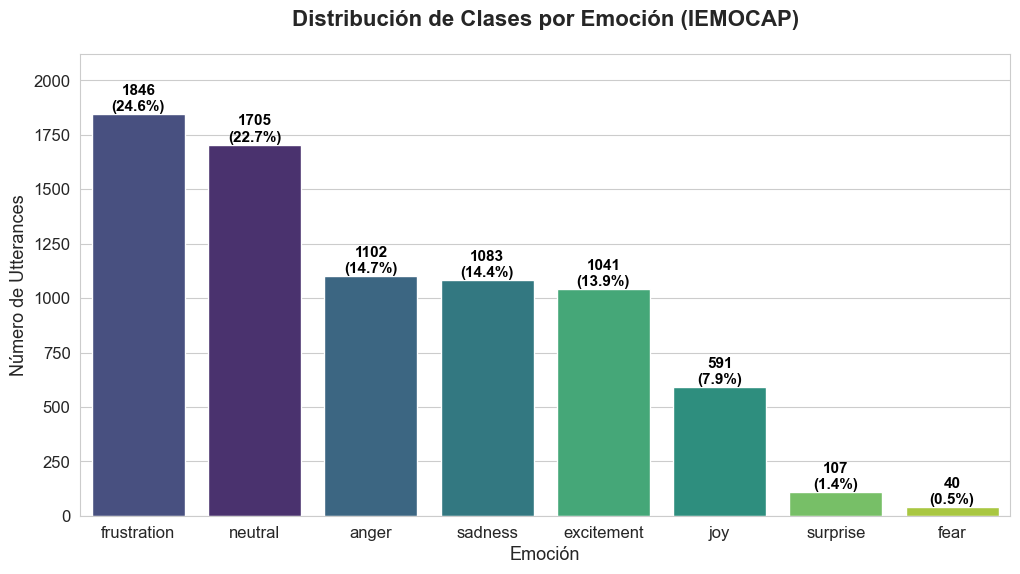

In [ ]:
# Configuración de estilo 
sns.set_style("whitegrid") 
plt.rcParams.update({'font.size': 12}) 

# --- 1. CONTEO DE EMOTION (GRÁFICO DE BARRAS) ---

plt.figure(figsize=(12, 6))

# Calculamos el orden de mayor a menor
order_list = df_iemocap['Emotion'].value_counts().index

# ------ 2. Creación del gráfico -----------
ax = sns.countplot(data=df_iemocap, 
                   x='Emotion', 
                   hue="Emotion", 
                   legend = False, 
                   order=order_list, 
                   palette='viridis')

plt.title('Distribución de Clases por Emoción (IEMOCAP)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoción', fontsize=13)
plt.ylabel('Número de Utterances', fontsize=13)

# Se añade en el gráfico el número y el % 
total = len(df_iemocap) 
for p in ax.patches:
    height = p.get_height() 
    percentage = '{:.1f}%'.format(100 * height / total)  
    ax.text(p.get_x() + p.get_width() / 2., height + 15,
            f'{int(height)}\n({percentage})', 
            ha="center", fontsize=11, color='black', fontweight='bold')

# Ajustamos los márgenes
plt.ylim(0, df_iemocap['Emotion'].value_counts().max() * 1.15) 
# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_13_1_EDA_IEMOCAP_DistribucionEmociones.png'), dpi=300)

plt.show()

A diferencia de **MELD** (dominado por *Neutral*), en IEMOCAP la clase mayoritaria es **Frustration** (**24.6%**), seguida muy de cerca por **Neutral** (**22.7%**). La emoción **Fear** representa apenas un **0.5%** (**40 muestras**). Esto confirma que intentar una clasificación multiclase pura sería inviable para esta etiqueta sin técnicas de *data augmentation*. Sin embargo, al agruparla dentro de la clase binaria **Estrés**, su impacto negativo se mitiga.

Los puntos en común con **MELD** es que se presenta una distribución desbalanceada (*Long Tail*). El **47.3%** de los datos se concentran en la **cabeza** (*Frustration* y *Neutral*), mientras que la **cola** (*Joy*, *Surprise*, *Fear*) apenas suma el 10% del total. 

A pesar de este desbalanceo, la agrupación propuesta por el **Modelo de Russell** aplicada para nuestra variable objetivo es favorable. Al sumar *Anger* (**14.7%**), *Frustration* (**24.6%**) y *Fear* (**0.5%**) dentro de la clase **Estrés**, obtenemos una representación mucho más sólida (casi el **40%** en total) que en **MELD**, facilitando el aprendizaje del modelo.

##### 1.2. Distribución de la Clase Objetivo (**target_stress**) y Desbalanceo.

A continuación, se analiza el desbalanceo existente en el conjunto de datos con respecto a la variable objetivo **target_stress** a través de un **Pie Chart**.

**** ESTADÍSTICAS DE DESBALANCEO ***
Total Muestras: 7515
Clase 0 (No Estrés): 4527
Clase 1 (Estrés): 2988
Ratio de Desbalanceo (IR): 1:1.52


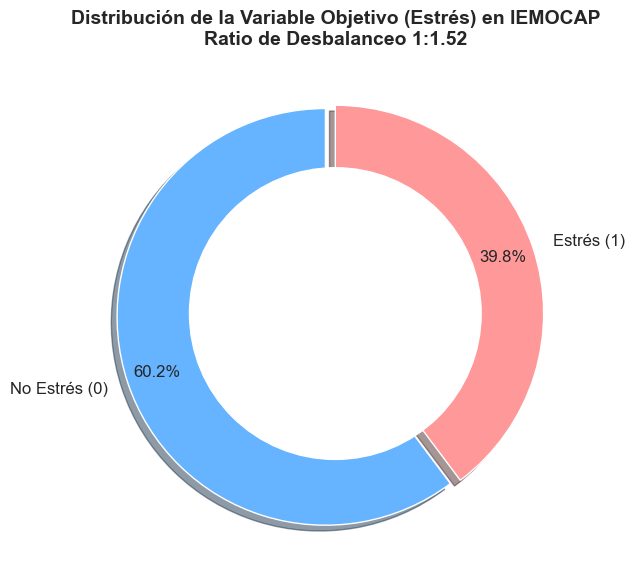

In [ ]:
conteo = df_iemocap['target_stress'].value_counts()
etiquetas = ['No Estrés (0)', 'Estrés (1)']
colores = ['#66b3ff', '#ff9999'] # Indicamos con color azul para No Estrés y color rojo para Estrés

# Se calcula el Ratio de Desbalanceo (Imbalance Ratio - IR)
n_neg = conteo[0] # Número de No Estrés (instancias negativas)
n_pos = conteo[1] # Número de Estrés (instancias positivas)
ratio = n_neg / n_pos # Ratio de Desbalanceo

print(f"**** ESTADÍSTICAS DE DESBALANCEO ***")
print(f"Total Muestras: {len(df_iemocap)}")
print(f"Clase 0 (No Estrés): {n_neg}")
print(f"Clase 1 (Estrés): {n_pos}")
print(f"Ratio de Desbalanceo (IR): 1:{ratio:.2f}")

# Gráfico de Donut
plt.figure(figsize=(8, 6))

plt.pie(conteo, 
        labels=etiquetas, 
        colors=colores,
        autopct='%1.1f%%', 
        startangle=90,
        pctdistance=0.85, 
        explode=(0.05, 0),  
        shadow=True) 

centre_circle = plt.Circle((0,0), 0.70, fc='white') 
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title(f'Distribución de la Variable Objetivo (Estrés) en IEMOCAP\nRatio de Desbalanceo 1:{ratio:.2f}', fontsize=14, fontweight='bold')
plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_13_2_EDA_IEMOCAP_PieChartEstres.png'), dpi=300)

plt.show()

En esta gráfica se confirma la gran ventaja de **IEMOCAP** frente a **MELD** para nuestra tarea de detección de **Estrés**, y es el balanceo de clases. 

Con un **Ratio de Desbalanceo (IR)** de 1:1.52, se considera un **desbalaceo leve**.

A diferencia de **MELD**, este *dataset* **no requiere** obligatoriamente de técnicas de *Data Augmentation*. Es probable que baste únicamente con aplicar pesos a las clases (`class_weights`) a la función de pérdida para compensar el ligero predominio de la clase negativa (**60.2%**).

Esto convierte a **IEMOCAP** en el principal *dataset* para que la red neuronal aprenda las características del estrés, mientras que **MELD** servirá más como prueba de robustez en escenarios desbalanceados.

#### **2. Análisis de la Estructura del Diálogo.**

##### 2.1. Conteo de Utterance_ID por Dialogue_ID (Histograma Discreto con Curva de Densidad KDE).

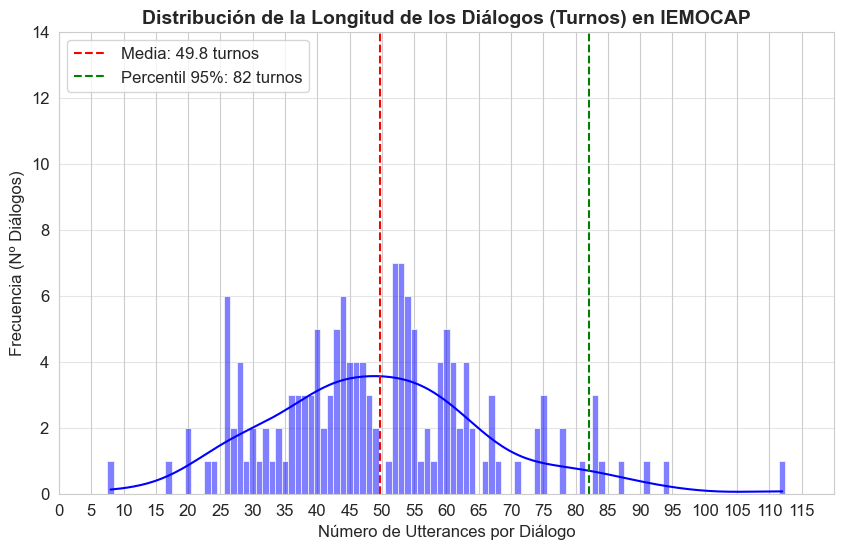

**** ESTADÍSTICAS DE PROFUNDIDAD DE DIÁLOGO ****
Longitud Mínima: 8 turnos
Longitud Máxima: 112 turnos
Si cortamos en 82 turnos, cubrimos el 95% de los casos.


In [ ]:
# --- ANÁLISIS DE LA ESTRUCTURA DEL DIÁLOGO (LONGITUD) ---

# 1. Calculamos cuántos utterances tiene cada diálogo
dialogue_lengths = df_iemocap.groupby('Dialogue_ID')['Utterance_ID'].count()

# 2. Histograma con curva de densidad (KDE)
plt.figure(figsize=(10, 6))
sns.histplot(dialogue_lengths,
             discrete=True,
             kde=True, 
             color='blue',
             edgecolor='white')

# Para una mayor claridad, mostramos un número cada 5 unidades en el eje X, hasta el 120.
# Y en el eje Y, se indican los números de 2 en 2 hasta el 15 (se ha adaptado de acuerdo a los valores obtenidos)
plt.xticks(np.arange(0, 120, 5)) 
plt.yticks(np.arange(0, 15, 2))

# 3. Se añaden líneas verticales para la media y el percentil 95 
mean_len = dialogue_lengths.mean()
p95_len = dialogue_lengths.quantile(0.95)

plt.axvline(mean_len, color='red', linestyle='--', label=f'Media: {mean_len:.1f} turnos')
plt.axvline(p95_len, color='green', linestyle='--', label=f'Percentil 95%: {p95_len:.0f} turnos')


plt.title('Distribución de la Longitud de los Diálogos (Turnos) en IEMOCAP', fontsize=14, fontweight='bold')
plt.xlabel('Número de Utterances por Diálogo', fontsize=12)
plt.ylabel('Frecuencia (Nº Diálogos)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.xlim(0, 120)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_15_EDA_IEMOCAP_DistribucionUtterances.png'), dpi=300)

plt.show()

# Se muestra un resumen estadístico:
print(f"**** ESTADÍSTICAS DE PROFUNDIDAD DE DIÁLOGO ****")
print(f"Longitud Mínima: {dialogue_lengths.min()} turnos")
print(f"Longitud Máxima: {dialogue_lengths.max()} turnos")
print(f"Si cortamos en {int(p95_len)} turnos, cubrimos el 95% de los casos.")

La media de turnos por diálogo es de **49.8**, una cifra superior a la observada en MELD (aprox. **10 turnos**). Esto indica que estamos ante interacciones profundas y sostenidas, no intercambios rápidos.

* El **percentil 95%** se sitúa en **82 turnos**.

* El **máximo** absoluto supera los **100 turnos**.

**Decisión Técnica:** Si con **MELD**, una ventana de contexto de **33 turnos** era suficiente, aquí resulta inútil. Para capturar la evolución del estrés en **IEMOCAP**, nuestro modelo deberá soportar secuencias de entrada de al menos **80-85 turnos** si queremos cubrir el 95% de los casos sin truncamiento excesivo. Esto exigirá mayor memoria computacional (VRAM).

#### **3. Análisis Textual (NLP).**

##### 3.1. Distribución de Longitud Textual (Word Count). Histograma Discreto con Curva de Densidad KDE.

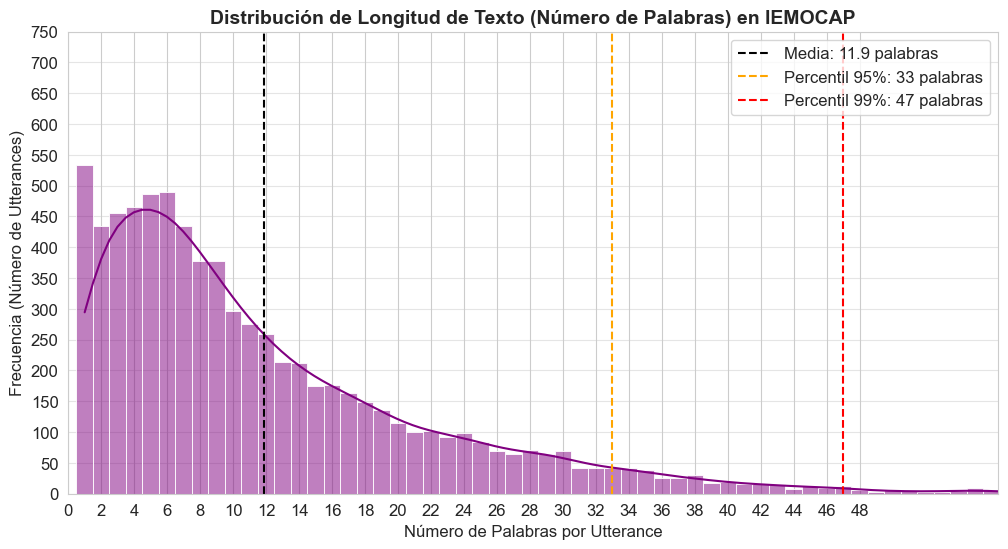


*** ESTADÍSTICAS DE LONGITUD (TOKENIZACIÓN)***
Longitud Mínima: 1 palabras
Longitud Máxima: 100 palabras
Media: 11.90 palabras
Percentil 95%: 33 palabras
Percentil 99%: 47 palabras


In [ ]:
# 1. Gráfico de Distribución (Histograma + KDE)
plt.figure(figsize=(12, 6))
sns.histplot(df_iemocap['word_count'], 
             discrete=True, 
             kde=True, 
             color='purple')

plt.xticks(np.arange(0, 50, 2)) 
plt.yticks(np.arange(0, 800, 50))

# 2. Líneas de referencia (Decisión de Diseño de max_length)
mean_words = df_iemocap['word_count'].mean()
p95_words = df_iemocap['word_count'].quantile(0.95)
p99_words = df_iemocap['word_count'].quantile(0.99)
max_words = df_iemocap['word_count'].max()

plt.axvline(mean_words, color='black', linestyle='--', label=f'Media: {mean_words:.1f} palabras')
plt.axvline(p95_words, color='orange', linestyle='--', label=f'Percentil 95%: {p95_words:.0f} palabras')
plt.axvline(p99_words, color='red', linestyle='--', label=f'Percentil 99%: {p99_words:.0f} palabras')

plt.title('Distribución de Longitud de Texto (Número de Palabras) en IEMOCAP', fontsize=14, fontweight='bold')
plt.xlabel('Número de Palabras por Utterance', fontsize=12)
plt.ylabel('Frecuencia (Número de Utterances)', fontsize=12)
plt.legend()
plt.xlim(0, p99_words * 1.2) # Cortamos el eje X un poco después del 99% para mostrarlo mucho mejor
plt.grid(axis='y', alpha=0.5)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_16_1_EDA_IEMOCAP_DistribucionTexto.png'), dpi=300)

plt.show()

# 4. Resumen de las stadísticas descriptivas 
print(f"\n*** ESTADÍSTICAS DE LONGITUD (TOKENIZACIÓN)***")
print(f"Longitud Mínima: {df_iemocap['word_count'].min()} palabras")
print(f"Longitud Máxima: {max_words} palabras")
print(f"Media: {mean_words:.2f} palabras")
print(f"Percentil 95%: {p95_words:.0f} palabras")
print(f"Percentil 99%: {p99_words:.0f} palabras")

**Decisión Técnica (Padding):** La distribución muestra un sesgo positivo notable. Aunque el máximo es de 100 palabras, el **99%** de los datos tiene menos de **47 palabras**.
Esto significa que para el modelo de NLP (BERT/RoBERTa), **no es eficiente** establecer una longitud máxima de 128 o 256 tokens (que añadiría mucho ruido y coste computacional en forma de *padding* de ceros). Se fijará por tanto un **`max_length`** de **60-64** tokens. Con este valor, cubrimos la totalidad de la información relevante (más del **99%** de los casos) sin desperdiciar memoria VRAM, optimizando el tiempo de entrenamiento.

##### 3.2. Análisis Semántico: Nube de Palabras (Wordcloud) para ESTRÉS y NO ESTRÉS.

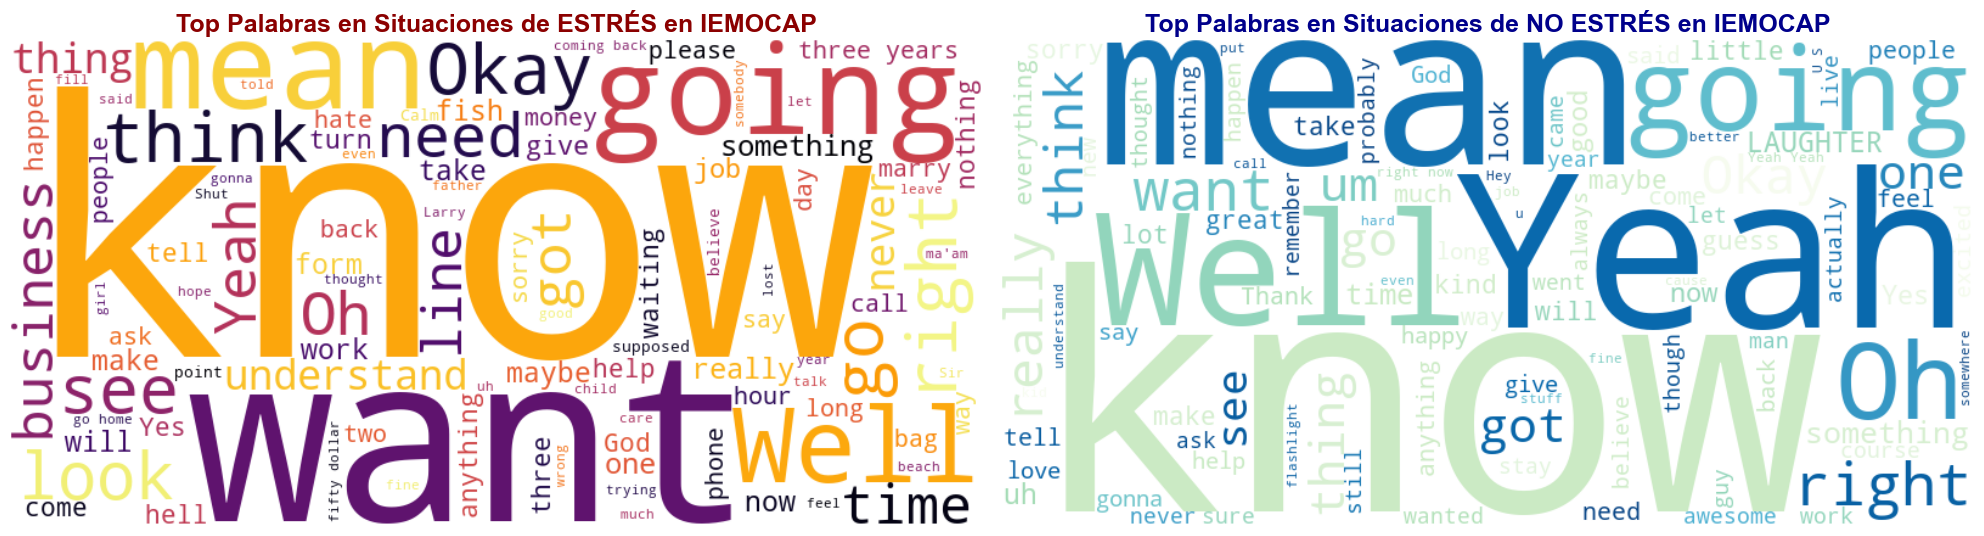

In [ ]:
# 1. Preparación del Texto
# Juntamos todas las frases de Estrés (1) en un solo texto 
text_stress = " ".join(df_iemocap[df_iemocap['target_stress'] == 1]['Text'].astype(str))

# Juntamos todas las frases de No-Estrés (0) en otro texto 
text_no_stress = " ".join(df_iemocap[df_iemocap['target_stress'] == 0]['Text'].astype(str))

# Definimos "Stopwords" (palabras vacías como 'the', 'a', 'is' que no aportan significado)
stopwords_set = set(STOPWORDS)

# 2. Configuración de la visualización
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # Establecemos 2 subplots

# --- NUBE 1: ESTRÉS (Usamos colores "calientes") ---
wc_stress = WordCloud(background_color='white', stopwords=stopwords_set, 
                      max_words=100, width=800, height=400, colormap='inferno').generate(text_stress)

axes[0].imshow(wc_stress, interpolation='bilinear')
axes[0].set_title('Top Palabras en Situaciones de ESTRÉS en IEMOCAP', fontsize=18, fontweight='bold', color='darkred')
axes[0].axis('off')

# --- NUBE 2: NO ESTRÉS (Usamos colores "fríos") ---
wc_no_stress = WordCloud(background_color='white', stopwords=stopwords_set, 
                         max_words=100, width=800, height=400, colormap='GnBu_r').generate(text_no_stress)

axes[1].imshow(wc_no_stress, interpolation='bilinear')
axes[1].set_title('Top Palabras en Situaciones de NO ESTRÉS en IEMOCAP', fontsize=18, fontweight='bold', color='darkblue')
axes[1].axis('off')

plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_17_EDA_IEMOCAP_NubePalabrasEstres.png'), dpi=300)

plt.show()

Las palabras más frecuentes en ambas clases (*know*, *mean*, *want*, *think*, *going*) son propias de la improvisación. Existe una alta colisión de palabras en ambas clases, al igual que ocurría con **MELD**.

Un modelo basado solo en frecuencia (como TF-IDF o Naive Bayes) fallaría estrepitosamente, ya que las *keywords* principales no discriminan entre Estrés y No-Estrés, algo ya comentado en el caso de **MELD**, justificando así la **Multimodalidad** de nuestro proyecto.

Nos llama la atención la aparición de ciertos marcadores emocionales:
* **Estrés:** Aparecen términos de valencia negativa o urgencia: *God*, *hell*, *hate*, *money*, *business*.
* **No Estrés:** Aparecen términos de asentimiento o suavidad: *yeah*, *laughter*, *sorry*, *love*.

El hecho de que palabras como *know* o *want* sea gigante en ambos lados confirma que **el contexto lo es todo**, ya que estas mismas palabras en contextos diferentes, pueden estar relacionadas con **Estrés** o **No Estrés**. Esto valida la necesidad de usar **BERT/RoBERTa** (embeddings contextuales) en lugar de conteo de palabras, y refuerza la importancia de apoyar al texto con otras modalidades, justificando así también la **Multimodalidad**.

#### **4. Consistencia Estadística de las Sesiones (Data Splits en IEMOCAP). Gráfico de Barras Comparativo.**

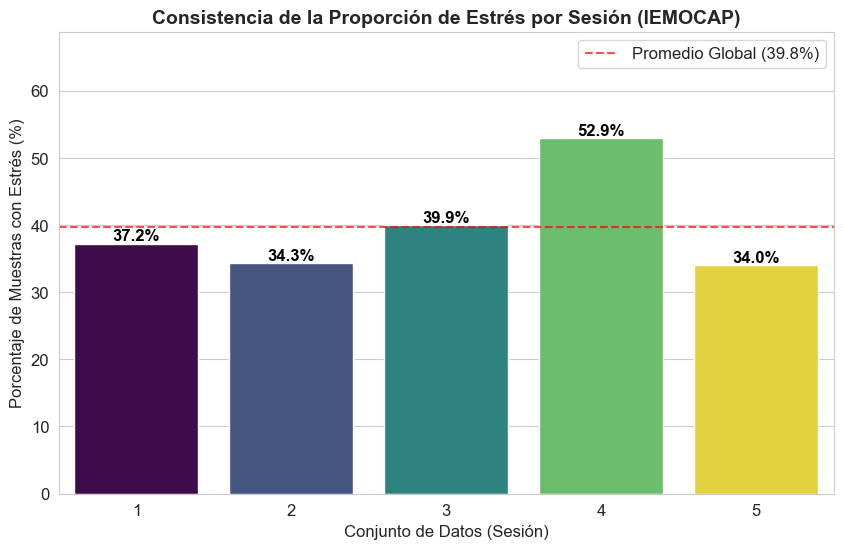

In [ ]:
# 1. Calculamos el % de Estrés en cada Session
# Agrupamos por sesión y calculamos la media de 'target_stress' (que equivale al % al multiplicar por 100)
split_stats = df_iemocap.groupby('Session')['target_stress'].mean() * 100
split_counts = df_iemocap['Session'].value_counts()

# Definimos el orden para el gráfico
order_sesion = [1,2,3,4,5]

# Reordenamos la serie para que coincida con el orden indicado
sesion_stats = split_stats.reindex(order_sesion)

# 2. Gráfico de Comparación
plt.figure(figsize=(10, 6))

# Gráfico de barras
ax = sns.barplot(x=split_stats.index, 
                 hue = split_stats.index, 
                 legend=False, 
                 y=split_stats.values, 
                 palette='viridis', 
                 order=order_sesion)

# Añadimos una línea global de referencia (indicando la media)
global_stress_rate = df_iemocap['target_stress'].mean() * 100
plt.axhline(global_stress_rate, color='red', linestyle='--', alpha=0.7, 
            label=f'Promedio Global ({global_stress_rate:.1f}%)')

plt.title('Consistencia de la Proporción de Estrés por Sesión (IEMOCAP)', fontsize=14, fontweight='bold')
plt.ylabel('Porcentaje de Muestras con Estrés (%)', fontsize=12)
plt.xlabel('Conjunto de Datos (Sesión)', fontsize=12)
plt.ylim(0, split_stats.max() * 1.3) # Dejamos un 30% de margen
plt.legend()

# 3. Etiquetamos cada barra con el porcentaje (altura)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5,
            f'{height:.1f}%',
            ha="center", fontsize=12, fontweight='bold', color='black')

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_14_EDA_IEMOCAP_ProporcionEstresSession.png'), dpi=300)

plt.show()

Esta gráfica muestra una distribución prácticamente uniforme entre las 5 sesiones del corpus (`Ses01` a `Ses05`). Cada sesión cuenta con aproximadamente el **20%** de los datos totales. No existen por tanto sesiones "gigantes" ni sesiones "vacías" que puedan sesgar el entrenamiento si se usan como conjunto de validación.


A diferencia de **MELD**, que venía con una partición fija (*train/dev/test*), la estructura homogénea de **IEMOCAP** nos permite implementar una validación cruzada tipo **Leave-One-Session-Out (LOSO)**.

* **Justificación Técnica:** Dado que en cada sesión participan dos hablantes únicos (que no aparecen en las otras), usar las sesiones como criterio de partición garantiza la **Independencia del Hablante (Speaker Independence)**. Esto asegura que el modelo no memorice las voces de los actores, sino que aprenda patrones de estrés generalizables.

### **BLOQUE II**: Análisis de Audio.

#### **1. Distribución Temporal de las Señales de Audio (Histograma Continuo de Duración de Audio).**

En **MELD**, se debía de abrir cada archivo de vídeo con `cv2` para saber la duración, ya que no se tienen las marcas de tiempo. 

Con **IEMOCAP**, al contar con las variables de `Start_Time` y `End_Time`, no hace falta leer los **7515** archivos de vídeo uno a uno, sino que podemos calcular la duración con una resta de estas dos columnas, lo cual es mucho más eficiente.

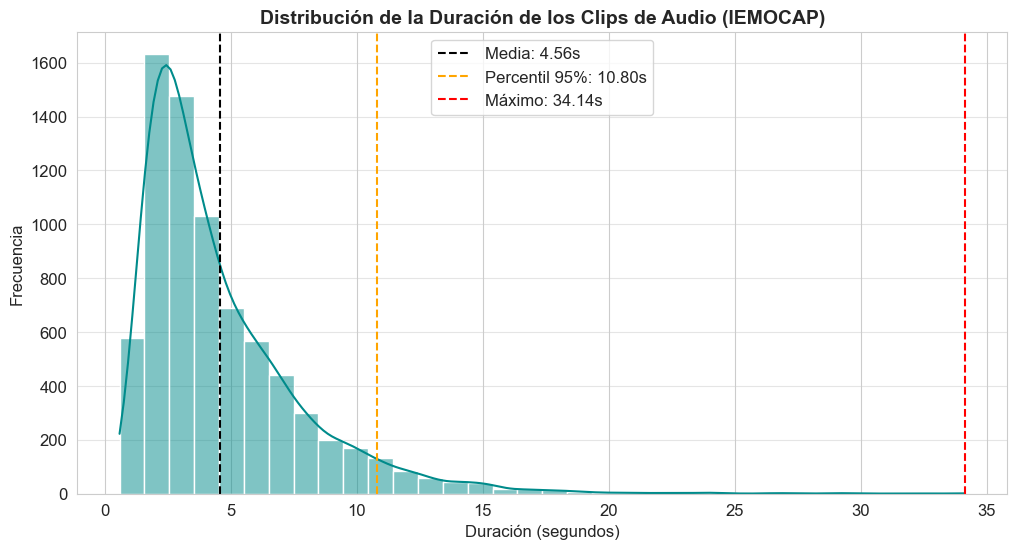

ESTADÍSTICAS DE AUDIO (IEMOCAP): 
Duración Mínima: 0.58 segundos
Duración Máxima: 34.14 segundos
Media: 4.56 segundos
Percentil 95%: 10.80 segundos
Percentil 99%: 15.31 segundos


In [ ]:
durations = df_iemocap['duration']

# --- GRÁFICO ---
plt.figure(figsize=(12, 6))

sns.histplot(durations, 
             binwidth=1,  # cada barra = 1 segundo
             kde=True, 
             color='darkcyan',
             edgecolor='white')

# Líneas de referencia (Padding/Truncation)
mean_dur = durations.mean()
max_dur = durations.max()
p95_dur = durations.quantile(0.95)
p99_dur = durations.quantile(0.99)

plt.axvline(mean_dur, color='black', linestyle='--', label=f'Media: {mean_dur:.2f}s')
plt.axvline(p95_dur, color='orange', linestyle='--', label=f'Percentil 95%: {p95_dur:.2f}s')
plt.axvline(max_dur, color='red', linestyle='--', label=f'Máximo: {max_dur:.2f}s')

plt.title('Distribución de la Duración de los Clips de Audio (IEMOCAP)', fontsize=14, fontweight='bold')
plt.xlabel('Duración (segundos)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

# Guardamos la imagen
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_18_1_EDA_IEMOCAP_DistribucionDuracionAudio.png'), dpi=300)

plt.show()

# Resumen Estadístico
print(f"ESTADÍSTICAS DE AUDIO (IEMOCAP): ")
print(f"Duración Mínima: {durations.min():.2f} segundos")
print(f"Duración Máxima: {durations.max():.2f} segundos")
print(f"Media: {mean_dur:.2f} segundos")
print(f"Percentil 95%: {p95_dur:.2f} segundos")
print(f"Percentil 99%: {p99_dur:.2f} segundos")

**Decisión Técnica (Input Shape):**
Al igual que en MELD, la distribución de la duración sigue una curva asimétrica positiva Tomar el máximo (**34s**) como referencia para el tamaño de la entrada sería un error, ya que se obligaría a rellenar con *padding* (silencio) la inmensa mayoría de los audios, desperdiciando memoria VRAM.

El percentil 95% se sitúa en **10.80 segundos**. Esto nos sugiere que fijando un límite de **11 segundos**, cubrimos casi la totalidad del dataset sin pérdida de información.

### **BLOQUE III**: Análisis de Vídeo.

#### **1. Muestreo Aleatorio de Frames (Grid de Imágenes).**

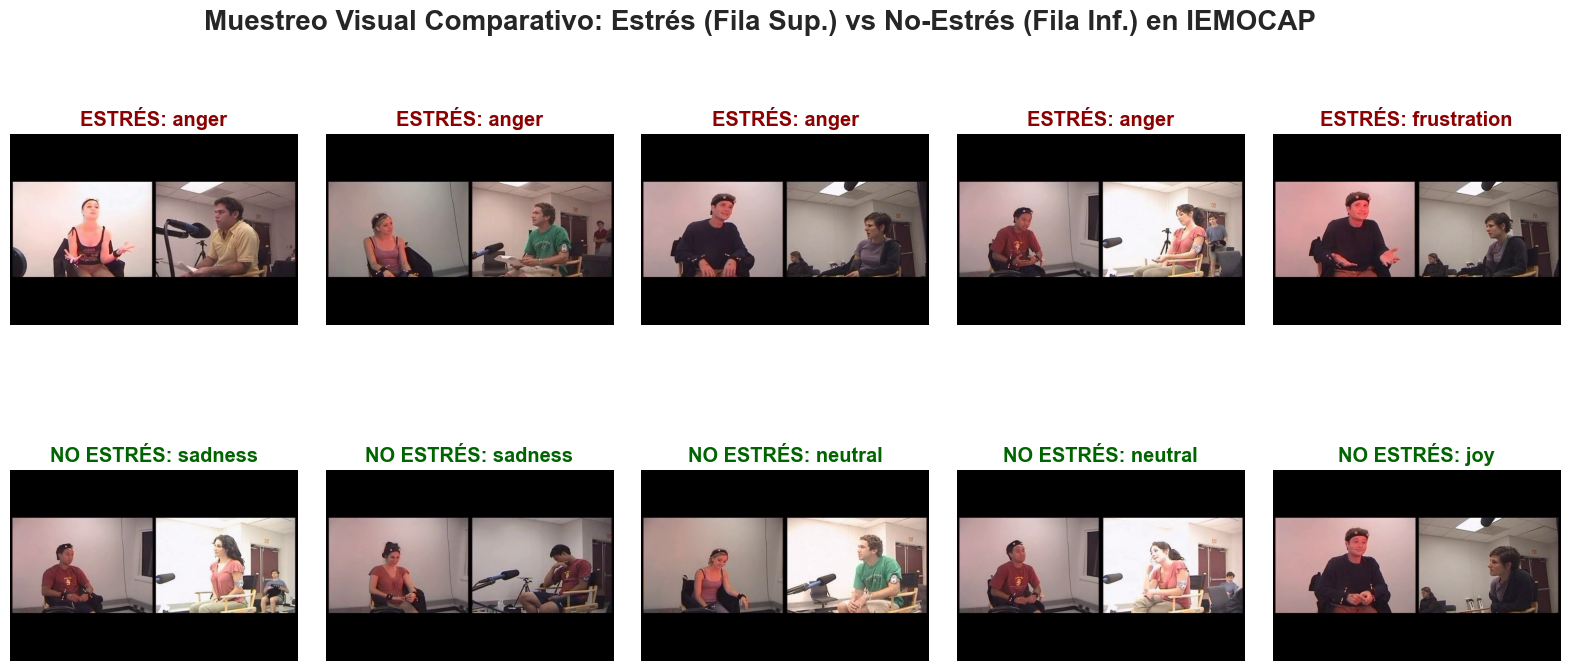

In [ ]:
# 1. Seleccionamos muestras aleatorias
# Cogemos 5 de estrés (valor 1) y 5 de no estrés (valor 0)
n_samples = 5
stress_samples = df_iemocap[df_iemocap['target_stress'] == 1].sample(n_samples, random_state=42)
no_stress_samples = df_iemocap[df_iemocap['target_stress'] == 0].sample(n_samples, random_state=42)

# 2. Creamos el Grid 
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # Establecemos 5 subplots en dos filas (total de 10)
plt.subplots_adjust(wspace=0.1, hspace=0.2) 

# Fila 1: ESTRÉS
for i, (_, row) in enumerate(stress_samples.iterrows()):
    frame = extract_frame(os.path.join(PROCESSED_PATH, row['Path_Video_Processed']))
    ax = axes[0, i] # En la primer fila se muestran los frames de aquellos vídeos etiquetados como "Estrés"
    if frame is not None:
        ax.imshow(frame) # Mostramos el frame en el subplot en cuestión
        ax.set_title(f"ESTRÉS: {row['Emotion']}", color='darkred', fontweight='bold')
    else:
        ax.text(0.5, 0.5, "Error lectura", ha='center') # En tal caso que no se pueda mostrar el frame, se muestra un error en el subplot
    ax.axis('off')

# Fila 2: NO ESTRÉS 
for i, (_, row) in enumerate(no_stress_samples.iterrows()):
    frame = extract_frame(os.path.join(PROCESSED_PATH,row['Path_Video_Processed']))
    ax = axes[1, i] # En la segunda fila se muestran los frames de aquellos vídeos etiquetados como "No Estrés"
    if frame is not None:
        ax.imshow(frame)
        ax.set_title(f"NO ESTRÉS: {row['Emotion']}", color='darkgreen', fontweight='bold')
    else:
        ax.text(0.5, 0.5, "Error lectura", ha='center')
    ax.axis('off')

plt.suptitle('Muestreo Visual Comparativo: Estrés (Fila Sup.) vs No-Estrés (Fila Inf.) en IEMOCAP', fontsize=20, fontweight='bold')

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_19_EDA_IEMOCAP_MuestreoVisual.png'), dpi=300)

plt.show()

En **MELD** se observaban cambios de plano, iluminación y escenarios diversos, mientras que en **IEMOCAP** se presenta un fondo estático y neutro (estudio de grabación) como podemos observar en las imágenes. Esto simplifica la tarea de la red neuronal visual, ya que no hay *ruido* de fondo que procesar.

El **desafío** principal de este *dataset* es que el modelo recibirá información visual de **ambos** interlocutores simultáneamente. Aunque esto enriquece el contexto (vemos la reacción del oyente), el modelo deberá aprender a discriminar (posiblemente con ayuda del audio) quién es el hablante activo que está expresando la emoción.

En la **fila superior (Estrés)** se observan principalmente gestos manuales y posturas de tensión o inclinación hacia delante, típicos de *Anger* y *Frustration*. Mientras que en la **fila inferior (No Estrés)** se observa una postura corporal decaída o hundida. En *Neutral*, la postura es relajada y estática.

### **BLOQUE IV**: Análisis Bivariante y Detección de Sesgos.

#### **1. Correlación Texto-Estrés (Longitud). Boxplot.**

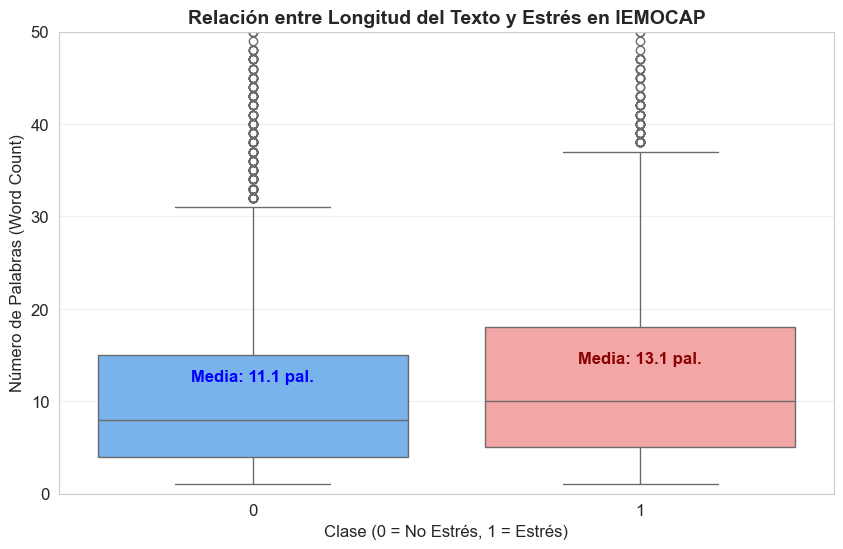

COMPARAMOS LA LONGITUD DE TEXTO:
Longitud Media (NO ESTRÉS):  11.12 palabras
Longitud Media (ESTRÉS): 13.07 palabras
Diferencia: 1.94 palabras


In [ ]:
# 1. Creamos el Boxplot
# Con este boxplot se muestra la Mediana (línea central), los Cuartiles (la caja) y los Outliers (puntos)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_iemocap, 
                 x = 'target_stress',
                 hue='target_stress', 
                 legend=False,
                 y='word_count', 
                 palette={0: '#66b3ff', 1: '#ff9999'}) # Azul y Rojo asignados a la variable objetivo

plt.title('Relación entre Longitud del Texto y Estrés en IEMOCAP', fontsize=14, fontweight='bold')
plt.xlabel('Clase (0 = No Estrés, 1 = Estrés)', fontsize=12)
plt.ylabel('Número de Palabras (Word Count)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 2. Se calculan las Medias para mostrar este dato también en el gráfico 
media_no_estres = df_iemocap[df_iemocap['target_stress'] == 0]['word_count'].mean()
media_estres = df_iemocap[df_iemocap['target_stress'] == 1]['word_count'].mean()

# Colocamos el dato de la media en la caja, para facilitar la comprensión
plt.text(0, media_no_estres + 1, f'Media: {media_no_estres:.1f} pal.', ha='center', fontweight='bold', color='blue')
plt.text(1, media_estres + 1, f'Media: {media_estres:.1f} pal.', ha='center', fontweight='bold', color='darkred')

# Limitamos el eje Y para ver mejor las cajas (cortamos los outliers extremos visualmente)
plt.ylim(0, 50) 

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_16_2_EDA_IEMOCAP_RelacionTextoEstres.png'), dpi=300)

plt.show()

# 3. Resumen Estadístico
print(f"COMPARAMOS LA LONGITUD DE TEXTO:")
print(f"Longitud Media (NO ESTRÉS):  {media_no_estres:.2f} palabras")
print(f"Longitud Media (ESTRÉS): {media_estres:.2f} palabras")
diferencia = media_estres - media_no_estres
print(f"Diferencia: {diferencia:.2f} palabras")

Aunque existe una ligera tendencia a que las frases de estrés sean más largas (posiblemente debido a la naturaleza argumentativa de la frustración en este *dataset*), la diferencia es realmente de apenas  **2 palabras**, lo cual resulta insignificante. Este mismo caso ocurría también en **MELD**, verficándose por tanto que más palabras no indica necesariamente que se trate de estrés.

Observando los *boxplots*, los rangos intercuartílicos (cajas) se solapan casi perfectamente. Esto indica que la variable `word_count` por sí sola **no es un predictor robusto**.

La longitud del texto (número de palabras) no es una variable que se le deba pasar de manera explícita al modelo, ya que no aporta suficiente información de nuestra variable objetivo **Estrés** (más palabras no implica **Estrés**). El peso de la clasificación deberá recaer totalmente en los **embeddings semánticos** y no en su cantidad.

#### **2. Correlación Audio-Estrés (Duración). Boxplot.**

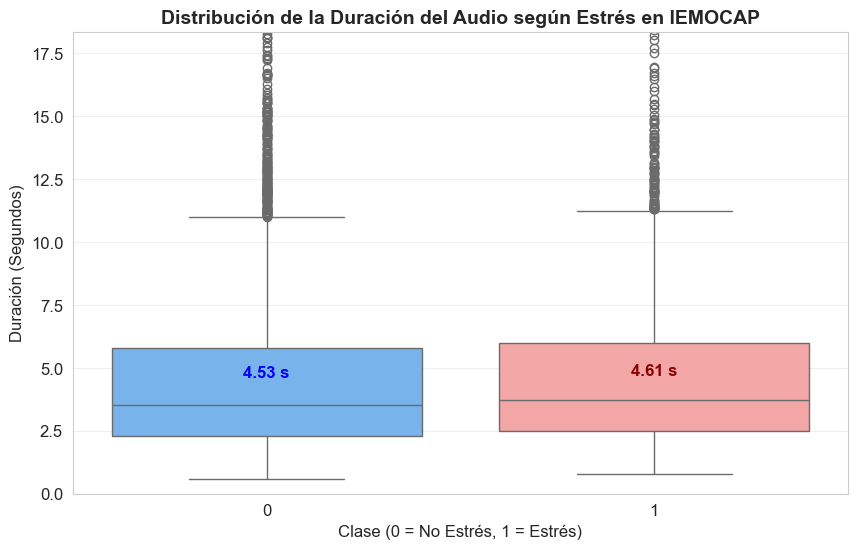

ANÁLISIS TEMPORAL: 
Duración Media (NO ESTRÉS):  4.53 segundos
Duración Media (ESTRÉS): 4.61 segundos
Diferencia: 0.09 segundos


In [ ]:
# 1. Boxplot: Duración por clase
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_iemocap, 
                 x='target_stress',
                 hue='target_stress', 
                 legend=False,
                 y='duration', 
                 palette={0: '#66b3ff', 1: '#ff9999'})

plt.title('Distribución de la Duración del Audio según Estrés en IEMOCAP', fontsize=14, fontweight='bold')
plt.xlabel('Clase (0 = No Estrés, 1 = Estrés)', fontsize=12)
plt.ylabel('Duración (Segundos)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 2. Calculamos y mostrar las medias (igual que el gráfico anterior, pero en este caso con la duración)
media_no_estres_dur = df_iemocap[df_iemocap['target_stress'] == 0]['duration'].mean()
media_estres_dur = df_iemocap[df_iemocap['target_stress'] == 1]['duration'].mean()

# Escribimos las medias en el gráfico
# Ajustamos la altura del texto (y) un poco por encima de la media para que se lea
plt.text(0, media_no_estres_dur + 0.1, f'{media_no_estres_dur:.2f} s', ha='center', fontweight='bold', color='blue')
plt.text(1, media_estres_dur + 0.1, f'{media_estres_dur:.2f} s', ha='center', fontweight='bold', color='darkred')

# Limitamos visualmente el eje Y si hay algún audio de 30 minutos que rompa la escala
# Usamos el percentil 99 que calculamos antes como límite lógico + un margen
limite_visual = df_iemocap['duration'].quantile(0.99) * 1.2
plt.ylim(0, limite_visual)

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_18_2_EDA_IEMOCAP_RelacionAudioEstres.png'), dpi=300)

plt.show()

# 4. Resumen estadístico
print(f"ANÁLISIS TEMPORAL: ")
print(f"Duración Media (NO ESTRÉS):  {media_no_estres_dur:.2f} segundos")
print(f"Duración Media (ESTRÉS): {media_estres_dur:.2f} segundos")
diff = media_estres_dur - media_no_estres_dur
print(f"Diferencia: {diff:.2f} segundos")

La diferencia entre las medias es de menos de una décima de segundo. Visualmente, los *boxplots* son idénticos en mediana, rango intercuartílico y outliers. Correlación muy baja o **nula**. 

Alimentar al modelo con la duración del *clip* (variable `duration` que hemos creado) no ayudará a distinguir si el sujeto está estresado o no. Misma conclusión extraída con respecto a la gráfica anterior para el análisis de la correlación del la longitud del texto y el estrés, donde podemos decir que ni más palabras ni audios más largos deben de apuntar necesariamente a un sujetos estresados.

Esta misma conclusión se obtenía con **MELD**.

#### **3. Análisis de Sesgo de Género (Gender Bias). Gráfico de Barras Apiladas.**

En el caso de **MELD**, se incluye junto con el *clip* de vídeo, el personaje de la serie *Friends* en dicho turno en cuestión. En **IEMOCAP**, no se tiene nombre ni información acerca de los personajes que interpretan o de los nombres de los actores, únicamente se indica el género. Por tanto, el análisis se realiza en cuanto al género del actor en cada turno o *utterance*.

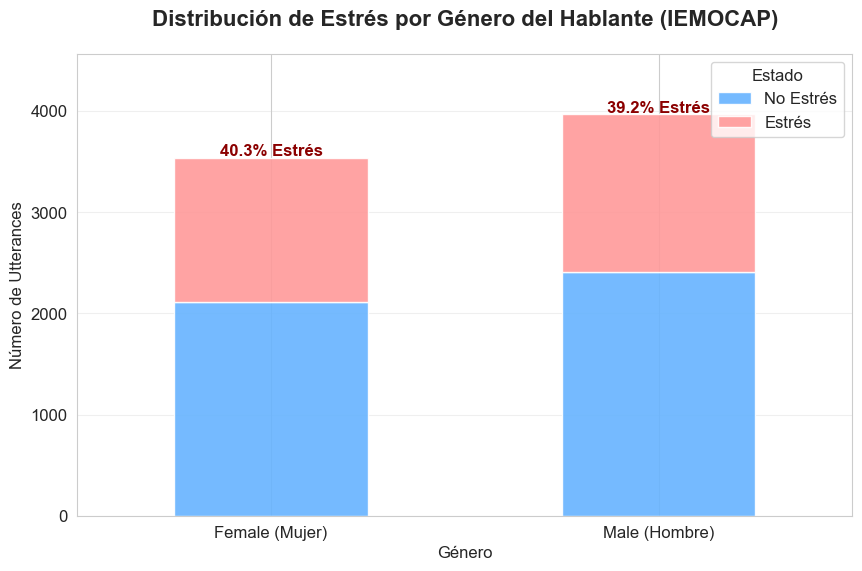

*** TABLA DE DATOS ***
target_stress      0     1
Gender_Label              
Female (Mujer)  2113  1429
Male (Hombre)   2414  1559

*** TASA DE ESTRÉS (en %) ***
Gender_Label
Female (Mujer)    40.344438
Male (Hombre)     39.239869
Name: target_stress, dtype: float64


In [ ]:
# 1. Creamos la variable de Género
df_iemocap['Gender'] = df_iemocap['Utterance_ID'].apply(lambda x: x.split('_')[-1][0])
df_iemocap['Gender_Label'] = df_iemocap['Gender'].map({'F': 'Female (Mujer)', 'M': 'Male (Hombre)'})

# 2. Tabla de Contingencia (Crosstab)
# Igual que en MELD: cruzamos el Género con el Estrés (0 y 1)
ct = pd.crosstab(df_iemocap['Gender_Label'], df_iemocap['target_stress'])

# 3. Gráfico de Barras Apiladas (Stacked Bar Plot)
ax = ct.plot(kind='bar', 
             stacked=True, 
             figsize=(10, 6), 
             color=['#66b3ff', '#ff9999'], # Azul (No Estrés), Rojo (Estrés)
             edgecolor='white',
             alpha=0.9)

plt.title('Distribución de Estrés por Género del Hablante (IEMOCAP)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Número de Utterances', fontsize=12)
plt.legend(['No Estrés', 'Estrés'], title='Estado', loc='upper right')
plt.xticks(rotation=0) 
plt.grid(axis='y', alpha=0.3)

# 4. Cálculo del % de Estrés
# Calculamos qué porcentaje del total de cada género es estrés
gender_bias = df_iemocap.groupby('Gender_Label')['target_stress'].mean() * 100

# 5. Añadimos el % encima de cada barra 
# Se recorre cada 'barra' (Categoría) añadiendo encima el valor (%) de estrés
for i, gender in enumerate(ct.index):
    # Altura total de la barra = es la suma de 0s y 1s
    y_pos = ct.loc[gender].sum() + 15 # Añadimos un poco de margen (+ 15)
    pct = gender_bias[gender]
    # Escribimos el texto
    ax.text(i, y_pos, 
            f'{pct:.1f}% Estrés', 
            ha='center', 
            fontweight='bold', 
            color='darkred',
            fontsize=12)

# Ajustamos márgenes superiores para que, visualmente, se perciba mucho mejor
plt.ylim(0, ct.sum(axis=1).max() * 1.15) 

# Guardamos la imagen
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_20_EDA_IEMOCAP_SesgoGenero.png'), dpi=300)

plt.show()

# Resumen numérico
print("*** TABLA DE DATOS ***")
print(ct)
print("\n*** TASA DE ESTRÉS (en %) ***")
print(gender_bias)

Se obtiene que la diferencia (*gap*) entre ambos géneros es de apenas un **1.1%**, por tanto, se obtiene una distribución casi idéntica de la clase positiva entre géneros. Esto permite que el modelo no aprenda correlaciones espurias del tipo "Mujer = Más Estresada" o "Hombre = Más Agresivo". Se permite por tanto alimentar al modelo con los datos tal cual, asegurando que el clasificador será equitativo en cuanto al género.

#### **4. Matriz de Correlación.**

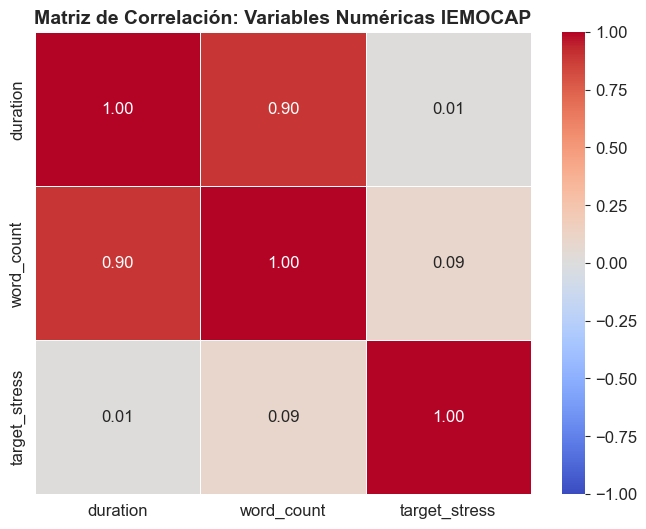

***** ANÁLISIS DE CORRELACIONES *****
Correlación Duración vs Palabras: 0.90
Correlación Estrés vs Duración: 0.01
Correlación Estrés vs Palabras: 0.09


In [ ]:
# 1. Seleccionamos solo las columnas numéricas relevantes
# Excluimos los IDs
cols_corr = ['duration', 'word_count', 'target_stress']
df_corr = df_iemocap[cols_corr]

# 2. Calculamos la matriz de correlación (Método Pearson)
# 1.0 = Correlación total (si una sube, la otra sube igual)
# 0.0 = Sin relación
# -1.0 = Correlación inversa (si una sube, la otra baja)
corr_matrix = df_corr.corr()

# 3. Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True, # Para indicar los números dentro
            cmap='coolwarm',  # Azul (frío) a Rojo (caliente)
            fmt=".2f",# Solo se indican 2 decimales
            linewidths=0.5,
            vmin=-1, vmax=1)  #Escala de -1 a 1

plt.title('Matriz de Correlación: Variables Numéricas IEMOCAP', fontsize=14, fontweight='bold')

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_21_EDA_IEMOCAP_MatrizCorrelacion.png'), dpi=300)

plt.show()

# 4. Interpretación 
print("***** ANÁLISIS DE CORRELACIONES *****")
dur_word_corr = corr_matrix.loc['duration', 'word_count']
stress_dur_corr = corr_matrix.loc['target_stress', 'duration']

print(f"Correlación Duración vs Palabras: {dur_word_corr:.2f}")
print(f"Correlación Estrés vs Duración: {stress_dur_corr:.2f}")
print(f"Correlación Estrés vs Palabras: {corr_matrix.loc['target_stress', 'word_count']:.2f}")

Se obtiene una **correlación positiva muy fuerte** (0.90) entre la duración (`duration`) del audio con respecto al número de palabras (`word_count`). Esto es lo lógico, ya que a mayor duración del audio, mayor número de palabras, algo contrario a lo que se obtenía en **MELD**, donde se presentaba una correlación de **0.41**, indicando que hay más silencios o cortes dramáticos, típicos de *sitcom*.

Esto indica que estas dos variables aportan información redundante (audios largos implica más palabras). Sin embargo, en nuestro proyecto, con Deep Learning Multimodal, procesaremos estas señales por separado (audio y texto) y sus *embeddings* internos, por lo que esta redundancia no es crítica.

En cuanto a la relación entre la variable objetivo y la duración/número de palabras, la correlación es prácticamente nula o desprecibale, algo que también ocurría en **MELD** y que hemos confirmado con las pruebas realizadas previamente.


Como conclusión, la matriz confirma matemáticamente que no podemos predecir el estrés basándonos en metadatos simples (longitud/duración). La señal de estrés está oculta en la **estructura profunda** de los datos (la entonación en el audio y la semántica en el texto), lo que justifica el uso de arquitecturas complejas de **Deep Learning (Transformers + CNNs)** capaces de extraer estas características latentes, en la misma línea a lo obtenido con **MELD**.

---

### **3. Análisis Dataset GLOBAL (`Multimodal_Stress_Dataset.csv`)**.

Para finalizar, se realiza la **Prueba de Integración** sobre el *dataset* global unificado para completar el **EDA** de esta sección.

Con esta **Prueba de Integración** se pretende, principalmente, analizar el **volumen** entre ambos *datasets*, y el **balanceo y comparación de clases global** para nuestra variable objetivo **Estrés**.

In [43]:
# Carga del dataset global unificado:

file_path = GLOBAL_CSV_PATH
if os.path.exists(file_path):
    df_global = pd.read_csv(file_path)
    display(df_global.head()) 
else:
    print(f"No se encuentra el archivo en {file_path}")

Utterance_ID Dialogue_ID                  video_path  \
0  train_dia0_utt0           0  train_splits/dia0_utt0.mp4   
1  train_dia0_utt1           0  train_splits/dia0_utt1.mp4   
2  train_dia0_utt2           0  train_splits/dia0_utt2.mp4   
3  train_dia0_utt3           0  train_splits/dia0_utt3.mp4   
4  train_dia0_utt4           0  train_splits/dia0_utt4.mp4   

                       audio_path  \
0  MELD_Audio/train_dia0_utt0.wav   
1  MELD_Audio/train_dia0_utt1.wav   
2  MELD_Audio/train_dia0_utt2.wav   
3  MELD_Audio/train_dia0_utt3.wav   
4  MELD_Audio/train_dia0_utt4.wav   

                                       Transcription  duration  split  \
0  also I was the point person on my company's tr...  5.672333  train   
1                   You must've had your hands full.  1.501500  train   
2                            That I did. That I did.  2.919583  train   
3      So let's talk a little bit about your duties.  2.752750  train   
4                              My duties? All right.  6.464792  train   

   target_stress dataset_origin  
0              0           MELD  
1              0           MELD  
2              0           MELD  
3              0           MELD  
4              0           MELD

### **EDA Global. Prueba de Integración.**

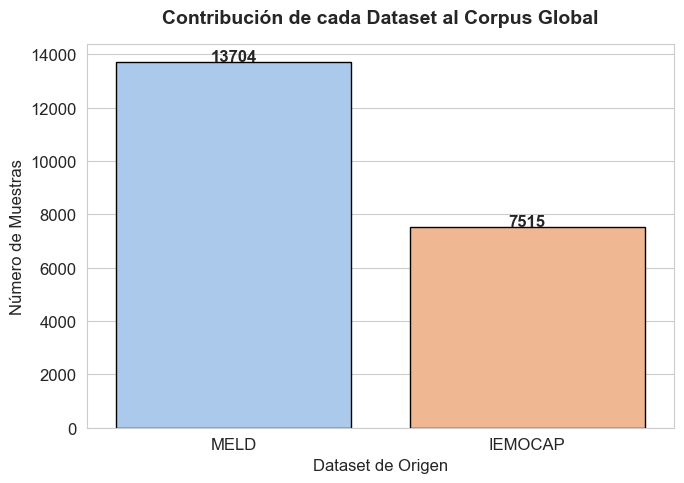

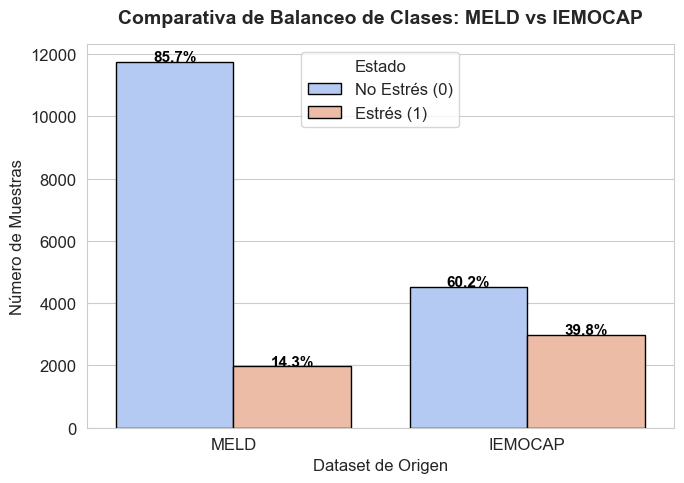

In [ ]:
# Se configura el diseño para mejorar el gráfico
sns.set_style("whitegrid")

plt.figure(figsize=(7,5))

# --- GRÁFICO 1 IZQUIERDA: Contribución de cada dataset (Volumen de datos) ---

ax1 = sns.countplot(data=df_global, 
              x='dataset_origin',
              hue = 'dataset_origin',
              legend=False,
              palette='pastel', 
              edgecolor='black'
              )
plt.title('Contribución de cada Dataset al Corpus Global', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Dataset de Origen', fontsize=12)
plt.ylabel('Número de Muestras', fontsize=12)

for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.text(p.get_x() + p.get_width()/2., height + 50,
                f'{int(height)}', ha="center", fontweight='bold', fontsize=12)

plt.tight_layout() # Para evitar que los títulos se superpongan
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_22_1_EDA_Global_Combined.png'), dpi=300)
plt.show()


# --- GRÁFICO 2 DERECHA: Balanceo de Clases Variable Objetivo Estrés ---
plt.figure(figsize=(7,5))
ax2 = sns.countplot(data=df_global, x='dataset_origin', hue='target_stress', palette='coolwarm', edgecolor='black')
plt.title('Comparativa de Balanceo de Clases: MELD vs IEMOCAP', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Dataset de Origen', fontsize=12)
plt.ylabel('Número de Muestras', fontsize=12)
plt.legend(title='Estado', labels=['No Estrés (0)', 'Estrés (1)'], loc='upper center')

total_meld = len(df_global[df_global['dataset_origin']=='MELD'])
total_iemocap = len(df_global[df_global['dataset_origin']=='IEMOCAP'])

for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        dataset_total = total_meld if p.get_x() < 0.5 else total_iemocap
        pct = 100 * height / dataset_total
        ax2.text(p.get_x() + p.get_width()/2., height + 20,
                f'{pct:.1f}%', ha="center", fontsize=11, fontweight='bold', color='black')

plt.tight_layout() # Para evitar que los títulos se superpongan
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_22_2_EDA_Global_Combined.png'), dpi=300)
plt.show()

Tras la concatenación, el DataFrame resultante `df_global` contiene **21219 muestras**. **MELD** aporta el **64.5%** de los datos (**13704 muestras**), actuando como la base de conocimiento generalista y ruidosa ("in-the-wild"), mientras que las **7515 muestras** aportadas por **IEMOCAP** aportan al *dataset* global unificado escenarios ideales con actores y entornos controlados.

### Distribución de Longitud (Texto y Audio).

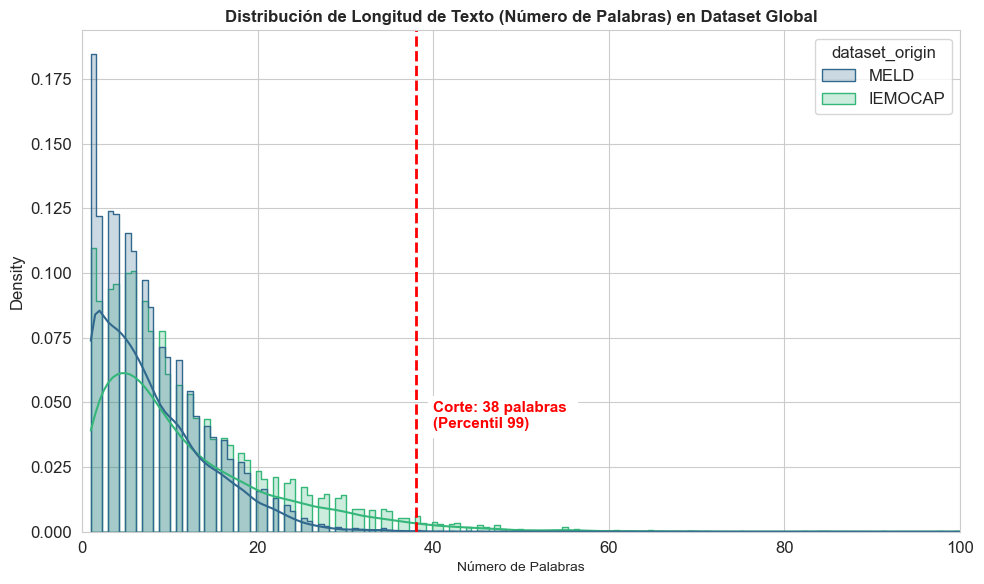

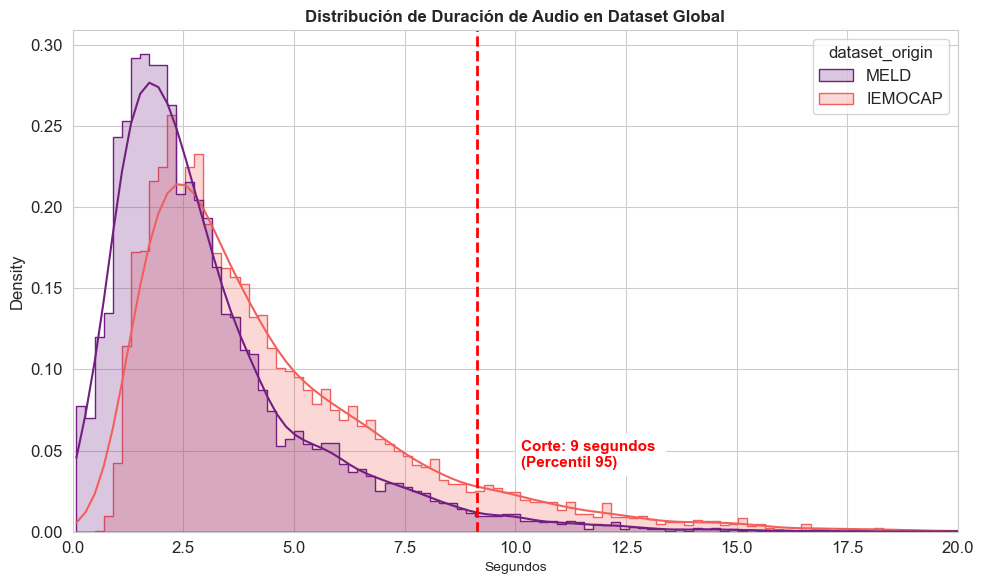

In [ ]:
# Se calcula el conteo de palabras a partir de Transcription
df_global['word_count'] = df_global['Transcription'].apply(lambda x: len(str(x).split()))


# --- GRÁFICO 1 IZQUIERDA: Distribución de Longitud de Texto ---
plt.figure(figsize=(10,6))
ax1 = sns.histplot(data=df_global, x='word_count', hue='dataset_origin', 
             kde=True, element="step", stat="density", common_norm=False, 
             palette='viridis')

# Línea de corte en 99% 
percentile_99_text= np.percentile(df_global['word_count'], 99) 
plt.axvline(percentile_99_text, color='red', linestyle='--', linewidth=2)
plt.text(x=percentile_99_text + 2, y=0.04, s=f'Corte: {int(percentile_99_text)} palabras \n(Percentil 99)', 
             color='red', fontweight='bold', fontsize=11, backgroundcolor='white')

plt.title('Distribución de Longitud de Texto (Número de Palabras) en Dataset Global', fontsize=12, fontweight='bold')
plt.xlabel('Número de Palabras', fontsize=10)
plt.xlim(0, 100) # Limitamos a 100 para más detalle

plt.tight_layout()
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_23_1_EDA_Global_Combined.png'), dpi=300)
plt.show()

# --- GRÁFICO 2 DERECHA: Distribución de Duración de Audio ---
plt.figure(figsize=(10,6))
ax2 = sns.histplot(data=df_global, x='duration', hue='dataset_origin', 
             kde=True, element="step", stat="density", common_norm=False, 
             palette='magma')

# Línea de corte en 11 segundos
percentile_95_audio = np.percentile(df_global['duration'], 95)
plt.axvline(percentile_95_audio, color='red', linestyle='--', linewidth=2)
plt.text(x=percentile_95_audio + 1, y=0.04, s=f'Corte: {int(percentile_95_audio)} segundos \n(Percentil 95)', 
             color='red', fontweight='bold', fontsize=11, backgroundcolor='white')
plt.title('Distribución de Duración de Audio en Dataset Global', fontsize=12, fontweight='bold')
plt.xlabel('Segundos', fontsize=10)
plt.xlim(0, 20) # Limitamos a 20s para más detalle

plt.tight_layout()
plt.savefig(os.path.join(FIGURAS_PATH,'Fig_3_23_2_EDA_Global_Combined.png'), dpi=300)
plt.show()

Tras analizar **MELD**, **IEMOCAP** y su integración **Global**, extraemos las siguientes **reglas de diseño** para nuestro sistema:

**1. Dimensionamiento de Inputs (Hiperparámetros):**
* **Texto (Tokenización):** El **99%** de las frases tienen hasta **47 palabras** (obtenido este resultado en el *dataset* de **IEMOCAP**, ya que con **MELD** el **99%** tiene hasta **27 palabras**). Fijaremos un **`max_length` de 60-64 tokens** para BERT/RoBERTa. Dado que los modelos Transformer dividen palabras en sub-tokens, se estima un ratio aproximado de 1.3 tokens por palabra. Por tanto, 47 palabras equivalen aproximadamente a 60 tokens. Al fijar el límite en **64**, garantizamos la cobertura total de MELD y del 99% de IEMOCAP, optimizando la memoria VRAM.

* **Audio (Duración):** El estrés no correlaciona con la duración. La mayoría de clips relevantes duran menos de *10s* tanto en **MELD** como **IEMOCAP**. Por tanto, fijaremos una ventana de audio de **~11 segundos**. Clips más largos se truncarán y aquellos más cortos se rellenarán (*padding*).

* **Contexto Conversacional:** Es el mayor desafío. MELD son diálogos cortos (de aprox. 10 turnos) e IEMOCAP son muy largos (de aprox. 50-80 turnos). El modelo deberá tener una memoria capaz de manejar dependencias de largo plazo.


**2. Selección de Características (Feature Engineering):**
Hemos demostrado estadísticamente que ni hablar más tiempo (`duration`) ni usar más palabras (`word_count`) implica mayor estrés (la correlación es prácticamente nula o despreciable). No alimentaremos al modelo con metadatos numéricos simples. La detección dependerá de la extracción de características profundas (**Embeddings**).

**3. Estrategia de Datos:**
**MELD** aporta volumen y robustez ante ruido (13k muestras). **IEMOCAP** aporta la señal clara de estrés para corregir el desbalanceo (39% positivos). Descartamos índices internos (`Unique_ID`) y nos quedamos con la clave compuesta `dataset_origin` + `Utterance_ID` para garantizar la trazabilidad total.